In [1]:
import gymnasium as gym
from LunarLander3DEnv.envs import LunarLander3DEnv  # Import environment
import time
from stable_baselines3.common.env_checker import check_env

env = gym.make("LunarLander3DEnv-v0",
                render_mode="human",
                )
check_env(env)
env.close()

Loading URDF from: c:\Users\User\Documents\DATA\Fitra Nurmayadi\TWSBR\twsbr\LunarLander3DEnv\envs\urdf\lunarlanderv2.urdf
Loading URDF from: c:\Users\User\Documents\DATA\Fitra Nurmayadi\TWSBR\twsbr\LunarLander3DEnv\envs\urdf\lunarlanderv2.urdf
Loading URDF from: c:\Users\User\Documents\DATA\Fitra Nurmayadi\TWSBR\twsbr\LunarLander3DEnv\envs\urdf\lunarlanderv2.urdf
Loading URDF from: c:\Users\User\Documents\DATA\Fitra Nurmayadi\TWSBR\twsbr\LunarLander3DEnv\envs\urdf\lunarlanderv2.urdf


In [ ]:
import pybullet as p
import pybullet_data
import time
# Hubungkan ke PyBullet dengan GUI
physicsClient = p.connect(p.GUI)

# Set direktori tambahan untuk file URDF
p.setAdditionalSearchPath(pybullet_data.getDataPath())

# Set gravitasi sesuai dengan lingkungan bulan (1.625 m/s² ke bawah)
p.setGravity(0, 0, -1.625)

# (Opsional) Muat plane sebagai permukaan bulan sederhana
planeId = p.loadURDF("plane.urdf")

# Muat URDF Lunar Lander
landerStartPos = [0, 0, 0]  # Posisi awal (x, y, z)
landerStartOrientation = p.getQuaternionFromEuler([0, 0, 0])
landerId = p.loadURDF("LunarLander3DEnv/envs/urdf/lunarlanderv2.urdf", landerStartPos, landerStartOrientation)

error: Cannot load URDF file.

In [ ]:
import gymnasium as gym
from LunarLander3DEnv.envs import LunarLander3DEnv  # Import environment
import time
import numpy as np
from stable_baselines3.common.env_checker import check_env

env = gym.make("LunarLander3DEnv-v0",
                render_mode="human",
                )
obs, info = env.reset()
terminated = False
truncated = False
acc_reward = 0  # Inisialisasi akumulasi reward
step = 0
while step < 1000 or not truncated:
    action = [0.0,
        #-x, y, -y, z, -z
        1,1,1,1,0,#front
        #x, y, -y, z, -z
        1,1,1,1,0, #back
        
        #x,-x,-y,z,-z
        1,1,1,1,0, #left
        #x,-x,y,z,-z
        1,1,1,1,0, #right
    ]
    obs, reward, terminated, truncated, info = env.step(action)
    acc_reward += reward
    print(f"\r {obs}", end="")
     #time.sleep(1/240)  # Delay agar gerakan terlihat
    if terminated or truncated:
        obs, info = env.reset()
    step += 1
    env.render()

print(f"Total reward: {acc_reward}")
env.close()

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from LunarLander3DEnv.envs import LunarLander3DEnv  # Pastikan environment sudah tersedia
from gymnasium import spaces
import tkinter as tk

class ObservationGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("Lunar Lander Observations & Actions")
        
        # Labels untuk Observasi
        self.obs_labels = [
            "pos_x", "pos_y", "pos_z", "roll", "pitch", "yaw",
            "lin_vel_x", "lin_vel_y", "lin_vel_z",
            "ang_vel_x", "ang_vel_y", "ang_vel_z",
            "fuel", "contact_1", "contact_2", "contact_3", "contact_4"
        ]
        
        tk.Label(root, text="Observations", font=("Arial", 14, "bold")).grid(row=0, column=0, columnspan=2, pady=5)
        self.obs_values = {}
        for i, label in enumerate(self.obs_labels):
            tk.Label(root, text=label, font=("Arial", 12)).grid(row=i+1, column=0, padx=10, pady=2, sticky="w")
            self.obs_values[label] = tk.Label(root, text="0.0000", font=("Arial", 12))
            self.obs_values[label].grid(row=i+1, column=1, padx=10, pady=2, sticky="w")

        # Labels untuk Aksi
        self.action_labels = [f"Action {i}" for i in range(21)]  # 21 nilai aksi
        tk.Label(root, text="Actions", font=("Arial", 14, "bold")).grid(row=0, column=2, columnspan=2, pady=5)
        self.action_values = {}
        for i, label in enumerate(self.action_labels):
            tk.Label(root, text=label, font=("Arial", 12)).grid(row=i+1, column=2, padx=10, pady=2, sticky="w")
            self.action_values[label] = tk.Label(root, text="0.0000", font=("Arial", 12))
            self.action_values[label].grid(row=i+1, column=3, padx=10, pady=2, sticky="w")
    
    def update(self, obs, action):
        obs_values = [f"{val:.4f}" for val in obs]  # Format observasi ke 4 desimal
        action_values = [f"{val:.4f}" for val in action]  # Format aksi ke 4 desimal
        
        # Update nilai observasi di GUI
        for key, val in zip(self.obs_values.keys(), obs_values):
            self.obs_values[key].config(text=val)
        
        # Update nilai aksi di GUI
        for key, val in zip(self.action_values.keys(), action_values):
            self.action_values[key].config(text=val)
# Definisikan kelas PID sederhana
class PID:
    def __init__(self, kp, ki, kd, dt, integrator_limit=np.inf):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.dt = dt
        self.integrator = 0.0
        self.prev_error = 0.0
        self.integrator_limit = integrator_limit

    def update(self, error):
        self.integrator += error * self.dt
        self.integrator = np.clip(self.integrator, -self.integrator_limit, self.integrator_limit)
        derivative = (error - self.prev_error) / self.dt
        self.prev_error = error
        return self.kp * error + self.ki * self.integrator + self.kd * derivative

class LanderPIDController:
    def __init__(self, dt, max_thrust, obs_min, obs_max):
        self.dt = dt
        self.max_thrust = max_thrust
        self.obs_min = obs_min
        self.obs_max = obs_max
    
        self.x_pos_pid = PID(kp=10.0, ki=1.0, kd=10.0, dt=dt, integrator_limit=10)
        self.y_pos_pid = PID(kp=10.0, ki=1.0, kd=10.0, dt=dt, integrator_limit=10)
        self.z_pos_pid = PID(kp=10.0, ki=1.0, kd=10.0, dt=dt, integrator_limit=10)

        self.x_vel_pid = PID(kp=100.0, ki=1.0, kd=10.0, dt=dt, integrator_limit=10)
        self.y_vel_pid = PID(kp=100.0, ki=1.0, kd=10.0, dt=dt, integrator_limit=10)
        self.z_vel_pid = PID(kp=100.0, ki=1.0, kd=10.0, dt=dt, integrator_limit=10)
        
        self.pitch_pid = PID(kp=10.0, ki=1.0, kd=10, dt=dt, integrator_limit=10)
        self.roll_pid  = PID(kp=10.0, ki=1.0, kd=10, dt=dt, integrator_limit=10)
        self.yaw_pid   = PID(kp=10.0, ki=1.0, kd=10, dt=dt, integrator_limit=10)
    
    def denormalize(self, norm_obs):
        return self.obs_min + (norm_obs + 1.0) * (self.obs_max - self.obs_min) / 2.0

    def compute_action(self, norm_obs):
        # Ambil nilai observasi (nilai ternormalisasi)
        pos = norm_obs[0:3]      # [x, y, z]
        orient = norm_obs[3:6]   # [roll, pitch, yaw]
        vel = norm_obs[6:9]      # Linear velocity
        
        # Hitung target z velocity secara interpolasi linear berdasarkan ketinggian
        target_vx = -pos[0]
        target_vy = -pos[1]
        target_vz = -pos[2] / 10.0

        x_vel_error = vel[0] - target_vx
        y_vel_error = vel[1] - target_vy
        z_vel_error = vel[2] - target_vz
        
        pitch_error = orient[1]  # target pitch = 0
        roll_error  = orient[0]  # target roll = 0
        yaw_error   = orient[2]  # target yaw = 0
        
        thrust_command = self.z_vel_pid.update(z_vel_error)
        lin_x_command = self.x_vel_pid.update(x_vel_error)
        lin_y_command = self.y_vel_pid.update(y_vel_error)

        pitch_correction = self.pitch_pid.update(pitch_error)
        roll_correction = self.roll_pid.update(roll_error)
        yaw_correction = self.yaw_pid.update(yaw_error)
        
        #Back -X | X Front
        #Right -Y | Y Left

        action = [
            #main
            -thrust_command,
            
            # Front
            #-x, +y, -y, +z, -z
            lin_x_command,       #good
            -yaw_correction,     #good
            yaw_correction,      #good
            pitch_correction,    #good
            -pitch_correction,   #good

            #Back
            #+x, +y, -y, +z, -z
            -lin_x_command,      #good
            yaw_correction,      #good
            -yaw_correction,     #good
            -pitch_correction,   #good
            pitch_correction,    #good

            #Left
            #+x, -x, -y, +z, -z
            yaw_correction,      #good
            -yaw_correction,     #good
            lin_y_command,       #good
            -roll_correction,    #good
            roll_correction,     #good

            #Right
            #+x, -x, +y, +z, -z
            -yaw_correction,     #good
            yaw_correction,      #good
            -lin_y_command,      #good
            roll_correction,     #good
            -roll_correction     #good
            
        ]

        #action =[  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

        
        
        action_vector = np.clip(action, 0, 1)

        return action_vector


if __name__ == '__main__':
    # Inisialisasi environment
    env = LunarLander3DEnv(render_mode='human')
    norm_obs, info = env.reset()
    
    dt = 1.0 / env.render_fps
    controller = LanderPIDController(dt, env.max_thrust, env.obs_min, env.obs_max)
    
    # Data logging untuk plotting
    obs_history = []
    action_history = []
    reward_history = []
    fuel_history = []
    step_history = []
    
    root = tk.Tk()
    gui = ObservationGUI(root)

    done = False
    while not done:
        
        if(norm_obs[2] < 0.80):
            action = controller.compute_action(norm_obs)
        else:
            action = [
                0,
                0,0,0,0,0,
                0,0,0,0,0,
                0,0,0,0,0,
                0,0,0,0,0]
        norm_obs, reward, terminated, truncated, info = env.step(action)
        action_history.append(action.copy())
        obs_history.append(norm_obs.copy())
        gui.update(norm_obs, action)
        root.update()
        
        reward_history.append(reward)
        # Asumsi fuel disimpan sebagai nilai asli di info (bila tidak, gunakan nilai fuel yang telah dihitung di env.fuel)
        fuel_history.append(norm_obs[12]))
        step_history.append(env.step_counter)
        done = terminated or truncated
        #print(f"Step: {env.step_counter}, Reward: {reward:.2f}, Fuel: {norm_obs[12]}, Z_pos: {norm_obs[2]:.4f} , {norm_obs[13:17]} | {norm_obs}  ", end="\r")
        
        env.render()
        time.sleep(dt/100)
    
    env.close()
    
    # Konversi list ke array untuk plotting
    obs_history = np.array(obs_history)       # shape: (n_steps, 17)
    action_history = np.array(action_history)   # shape: (n_steps, 21)
    reward_history = np.array(reward_history)
    fuel_history = np.array(fuel_history)
    step_history = np.array(step_history)
    
    # Plot grafik data
    fig, axs = plt.subplots(4, 2, figsize=(14, 12))
    
    # (0,0): Reward and Fuel over Steps
    ax0 = axs[0, 0]
    ax0.plot(step_history, reward_history, label='Reward per Step', color='blue')
    ax0.set_xlabel('Step')
    ax0.set_ylabel('Reward', color='blue')
    ax0.set_title('Reward and Fuel over Steps')
    ax0.legend(loc='upper left')
    ax0b = ax0.twinx()
    ax0b.plot(step_history, fuel_history, 'r--', label='Fuel', linewidth=2)
    ax0b.set_ylabel('Fuel', color='red')
    ax0b.legend(loc='upper right')
    
    # (0,1): Observasi - Posisi (pos_x, pos_y, pos_z)
    obs_labels_pos = ["pos_x", "pos_y", "pos_z"]
    obs_subset_pos = obs_history[:, 0:3]
    for i in range(obs_subset_pos.shape[1]):
        axs[0, 1].plot(step_history, obs_subset_pos[:, i], label=obs_labels_pos[i])
    axs[0, 1].set_xlabel('Step')
    axs[0, 1].set_ylabel('Normalized Observation')
    axs[0, 1].set_title('Observation - Position per Step')
    axs[0, 1].legend()
    
    # (1,0): Observasi - Orientasi (roll, pitch, yaw)
    obs_labels_ori = ["roll", "pitch", "yaw"]
    obs_subset_ori = obs_history[:, 3:6]
    for i in range(obs_subset_ori.shape[1]):
        axs[1, 0].plot(step_history, obs_subset_ori[:, i], label=obs_labels_ori[i])
    axs[1, 0].set_xlabel('Step')
    axs[1, 0].set_ylabel('Normalized Observation')
    axs[1, 0].set_title('Observation - Orientation per Step')
    axs[1, 0].legend()
    
    # (1,1): Observasi - Linear Velocities (lin_vel_x, lin_vel_y, lin_vel_z)
    obs_labels_lin_vel = ["lin_vel_x", "lin_vel_y", "lin_vel_z"]
    obs_subset_lin_vel = obs_history[:, 6:9]
    for i in range(obs_subset_lin_vel.shape[1]):
        axs[1, 1].plot(step_history, obs_subset_lin_vel[:, i], label=obs_labels_lin_vel[i])
    axs[1, 1].set_xlabel('Step')
    axs[1, 1].set_ylabel('Normalized Observation')
    axs[1, 1].set_title('Observation - Linear Velocity per Step')
    axs[1, 1].legend()
    
    # (2,0): Observasi - Angular Velocities (ang_vel_x, ang_vel_y, ang_vel_z)
    obs_labels_ang_vel = ["ang_vel_x", "ang_vel_y", "ang_vel_z"]
    obs_subset_ang_vel = obs_history[:, 9:12]
    for i in range(obs_subset_ang_vel.shape[1]):
        axs[2, 0].plot(step_history, obs_subset_ang_vel[:, i], label=obs_labels_ang_vel[i])
    axs[2, 0].set_xlabel('Step')
    axs[2, 0].set_ylabel('Normalized Observation')
    axs[2, 0].set_title('Observation - Angular Velocity per Step')
    axs[2, 0].legend()
    
    # (2,1): Action per Step (21 dimensi) dengan label sederhana
    for i in range(action_history.shape[1]):
        axs[2, 1].plot(step_history, action_history[:, i], label=f'Action {i}')
    axs[2, 1].set_xlabel('Step')
    axs[2, 1].set_ylabel('Normalized Action')
    axs[2, 1].set_title('Action per Step')
    axs[2, 1].legend(fontsize='small', ncol=3)
    
    # (3,0): Observasi - Contact (4 dimensi)
    contact_labels = ["Contact 1", "Contact 2", "Contact 3", "Contact 4"]
    obs_subset_contact = obs_history[:, 13:17]
    for i in range(obs_subset_contact.shape[1]):
        axs[3, 0].plot(step_history, obs_subset_contact[:, i], label=contact_labels[i])
    axs[3, 0].set_xlabel('Step')
    axs[3, 0].set_ylabel('Normalized Observation')
    axs[3, 0].set_title('Observation - Contact per Step')
    axs[3, 0].legend()
     
    plt.tight_layout()
    plt.show()
    

SyntaxError: unmatched ')' (55019045.py, line 203)

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import ttk
from LunarLander3DEnv.envs import LunarLander3DEnv  # Pastikan environment sudah tersedia
from gymnasium import spaces
import threading
########################################
# PID Controller Class
########################################



class PID:
    def __init__(self, kp, ki, kd, dt, integrator_limit=np.inf):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.dt = dt
        self.integrator = 0.0
        self.prev_error = 0.0
        self.integrator_limit = integrator_limit

    def update(self, error):
        p_term = self.kp * error
        self.integrator += error * self.dt
        self.integrator = np.clip(self.integrator, -self.integrator_limit, self.integrator_limit)
        i_term = self.ki * self.integrator
        d_term = self.kd * ((error - self.prev_error) / self.dt)
        self.prev_error = error
        return p_term + i_term + d_term, p_term, i_term, d_term

########################################
# Combined Display (Tkinter GUI)
# Menampilkan PID parameters dan Observations & Actions
########################################


class CombinedDisplay(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("Lunar Lander: PID, Observations & Actions")
        self.geometry("1200x600")
        
        # Buat frame utama untuk tiga kolom
        self.obs_frame = ttk.LabelFrame(self, text="Observations", padding=(10, 10))
        self.obs_frame.grid(row=0, column=0, padx=10, pady=10, sticky="nsew")
        
        self.act_frame = ttk.LabelFrame(self, text="Actions", padding=(10, 10))
        self.act_frame.grid(row=0, column=1, padx=10, pady=10, sticky="nsew")
        
        self.pid_frame = ttk.LabelFrame(self, text="PID Control", padding=(10, 10))
        self.pid_frame.grid(row=0, column=2, padx=10, pady=10, sticky="nsew")
        
        self._create_obs_widgets()
        self._create_act_widgets()
        self._create_pid_widgets()
        
        self.grid_columnconfigure(0, weight=1)
        self.grid_columnconfigure(1, weight=1)
        self.grid_columnconfigure(2, weight=2)
    
    def _create_obs_widgets(self):
        self.obs_labels = {}
        obs_names = ["pos_x", "pos_y", "pos_z", "roll", "pitch", "yaw",
                     "lin_vel_x", "lin_vel_y", "lin_vel_z",
                     "ang_vel_x", "ang_vel_y", "ang_vel_z",
                     "fuel", "contact_1", "contact_2", "contact_3", "contact_4"]
        for i, name in enumerate(obs_names):
            ttk.Label(self.obs_frame, text=name, font=("Arial", 10)).grid(row=i, column=0, padx=5, pady=2, sticky="w")
            self.obs_labels[name] = ttk.Label(self.obs_frame, text="0.0000", font=("Arial", 10))
            self.obs_labels[name].grid(row=i, column=1, padx=5, pady=2, sticky="w")
    
    def _create_act_widgets(self):
        self.action_labels = {}
        for i in range(21):
            action_name = f"Action {i}"
            ttk.Label(self.act_frame, text=action_name, font=("Arial", 10)).grid(row=i, column=0, padx=5, pady=2, sticky="w")
            self.action_labels[action_name] = ttk.Label(self.act_frame, text="0.0000", font=("Arial", 10))
            self.action_labels[action_name].grid(row=i, column=1, padx=5, pady=2, sticky="w")
    
    def _create_pid_widgets(self):
        self.pid_labels = {}
        parameters = ["z", "roll", "pitch", "yaw"]
        components = ["PID Output", "Error", "Prev Error", "P", "I", "D"]
        
        for j, text in enumerate(["Parameter"] + components):
            ttk.Label(self.pid_frame, text=text, font=("Arial", 12)).grid(row=0, column=j, padx=5, pady=5)
        
        for i, param in enumerate(parameters):
            ttk.Label(self.pid_frame, text=param.upper(), font=("Arial", 12)).grid(row=i+1, column=0, padx=5, pady=5, sticky="w")
            for j, comp in enumerate(components):
                lbl = ttk.Label(self.pid_frame, text="0.0000", font=("Arial", 10))
                lbl.grid(row=i+1, column=j+1, padx=5, pady=5, sticky="w")
                self.pid_labels[f"{param}_{comp}"] = lbl
    
    def update_values(self, pid_data, obs, action):
        # Update Observations
        for key, val in zip(self.obs_labels.keys(), obs):
            self.obs_labels[key].config(text=f"{val:.4f}")
        
        # Update Actions
        for key, val in zip(self.action_labels.keys(), action):
            self.action_labels[key].config(text=f"{val:.4f}")
        
        # Update PID
        for key, value in pid_data.items():
            self.pid_labels[key].config(text=f"{value:.4f}")
        
        self.update()

    

########################################
# Lander PID Controller (21 Action Space)
########################################

class LanderPIDController:
    def __init__(self, dt, max_thrust, obs_min, obs_max):
        self.dt = dt
        self.max_thrust = max_thrust
        self.obs_min = obs_min
        self.obs_max = obs_max
    
        self.x_pos_pid = PID(kp=10.0, ki=1.0, kd=10.0, dt=dt, integrator_limit=10)
        self.y_pos_pid = PID(kp=10.0, ki=1.0, kd=10.0, dt=dt, integrator_limit=10)
        self.z_pos_pid = PID(kp=10.0, ki=1.0, kd=10.0, dt=dt, integrator_limit=10)

        self.x_vel_pid = PID(kp=100.0, ki=1.0, kd=10.0, dt=dt, integrator_limit=10)
        self.y_vel_pid = PID(kp=100.0, ki=1.0, kd=10.0, dt=dt, integrator_limit=10)
        self.z_vel_pid = PID(kp=100.0, ki=1.0, kd=10.0, dt=dt, integrator_limit=10)
        
        self.pitch_pid = PID(kp=10.0, ki=1.0, kd=10, dt=dt, integrator_limit=10)
        self.roll_pid  = PID(kp=10.0, ki=1.0, kd=10, dt=dt, integrator_limit=10)
        self.yaw_pid   = PID(kp=10.0, ki=1.0, kd=10, dt=dt, integrator_limit=10)
    
    def denormalize(self, norm_obs):
        return self.obs_min + (norm_obs + 1.0) * (self.obs_max - self.obs_min) / 2.0

    def compute_action(self, norm_obs):
        # Ambil nilai observasi (nilai ternormalisasi)
        pos = norm_obs[0:3]      # [x, y, z]
        orient = norm_obs[3:6]   # [roll, pitch, yaw]
        vel = norm_obs[6:9]      # Linear velocity
        
        # Hitung target z velocity secara interpolasi linear berdasarkan ketinggian
        target_vx = -pos[0]
        target_vy = -pos[1]
        target_vz = -pos[2] / 10.0

        x_vel_error = vel[0] - target_vx
        y_vel_error = vel[1] - target_vy
        z_vel_error = vel[2] - target_vz
        
        roll_error  = orient[0]  # target roll = 0
        pitch_error = orient[1]  # target pitch = 0
        yaw_error   = orient[2]  # target yaw = 0
        
        thrust_command, p_z, i_z, d_z = self.z_vel_pid.update(z_vel_error)
        lin_x_command, p_z, i_z, d_z = self.x_vel_pid.update(x_vel_error)
        lin_y_command, p_z, i_z, d_z = self.y_vel_pid.update(y_vel_error)

        pitch_correction, p_p, i_p, d_p = self.pitch_pid.update(pitch_error)
        roll_correction, p_r, i_r, d_r = self.roll_pid.update(roll_error)
        yaw_correction, p_y, i_y, d_y = self.yaw_pid.update(yaw_error)
        
        pid_data = {
                    "z_PID Output": thrust_command, "z_Error": z_vel_error, "z_P": p_z, "z_I": i_z, "z_D": d_z,
                    "pitch_PID Output": pitch_correction, "pitch_Error": pitch_error, "pitch_P": p_p, "pitch_I": i_p, "pitch_D": d_p,
                    "roll_PID Output": roll_correction, "roll_Error": roll_error, "roll_P": p_r, "roll_I": i_r, "roll_D": d_r,
                    "yaw_PID Output": yaw_correction, "yaw_Error": yaw_error, "yaw_P": p_y, "yaw_I": i_y, "yaw_D": d_y
                    }

        #Back -X | X Front
        #Right -Y | Y Left

        action = [
            #main
            -thrust_command,
            
            # Front
            #-x, +y, -y, +z, -z
            lin_x_command,       #good
            -yaw_correction,     #good
            yaw_correction,      #good
            pitch_correction,    #good
            -pitch_correction,   #good

            #Back
            #+x, +y, -y, +z, -z
            -lin_x_command,      #good
            yaw_correction,      #good
            -yaw_correction,     #good
            -pitch_correction,   #good
            pitch_correction,    #good

            #Left
            #+x, -x, -y, +z, -z
            yaw_correction,      #good
            -yaw_correction,     #good
            lin_y_command,       #good
            -roll_correction,    #good
            roll_correction,     #good

            #Right
            #+x, -x, +y, +z, -z
            -yaw_correction,     #good
            yaw_correction,      #good
            -lin_y_command,      #good
            roll_correction,     #good
            -roll_correction     #good
            
        ]

        #action =[  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

        
        
        action_vector = np.clip(action, 0, 1)

        return action_vector, pid_data

########################################
# Program Utama: Inferensi, GUI, dan Plotting
########################################

def run_gui():
    gui.mainloop()

gui = CombinedDisplay()
gui_thread = threading.Thread(target=run_gui, daemon=True)
gui_thread.start()


if __name__ == '__main__':
    # Inisialisasi environment
    env = LunarLander3DEnv(render_mode='human')
    norm_obs, info = env.reset()
    env.render()
    dt = 1.0 / env.render_fps
    controller = LanderPIDController(dt, env.max_thrust, env.obs_min, env.obs_max)
    
    
    # Data logging untuk plotting
    obs_history = []
    action_history = []
    reward_history = []
    fuel_history = []
    step_history = []
    prev_position = np.array(norm_obs[:3])  # Simpan posisi awal (x, y, z)
    update_distance = 0.5  # Jarak minimum untuk update GUI
    done = False
    while not done:
        action, pid_data = controller.compute_action(norm_obs)
        action_history.append(action.copy())
                
        norm_obs, reward, terminated, truncated, info = env.step(action)
        obs_history.append(norm_obs.copy())
        reward_history.append(reward)
        fuel_history.append(norm_obs[12])
        step_history.append(env.step_counter)
        done = terminated or truncated
        
        current_position = np.array(norm_obs[:3])  # Ambil posisi saat ini
        distance_moved = np.linalg.norm(current_position - prev_position)  # Hitung jarak berpindah
        
        # Perbarui GUI dengan PID, Observasi, dan Aksi
        gui.update_values(pid_data, norm_obs, action)
        env.render()
        if distance_moved >= update_distance:
              # Render ulang PyBullet
            prev_position = current_position  # Reset posisi sebelumnya
           
        # time.sleep(dt)
    
    env.close()
        # time.sleep(1/env.render_fps)  # Uncomment untuk real-time simulation
    
    # Konversi data ke numpy array
    obs_history = np.array(obs_history)
    action_history = np.array(action_history)
    reward_history = np.array(reward_history)
    fuel_history = np.array(fuel_history)
    step_history = np.array(step_history)
    
# Plotting
fig, axs = plt.subplots(4, 2, figsize=(14, 12))

# Plot 1: Reward dan Fuel
ax = axs[0, 0]
ax.plot(step_history, reward_history, 'b-', label='Reward')
ax.set_xlabel('Step')
ax.set_ylabel('Reward', color='b')
ax.tick_params(axis='y', labelcolor='b')

axb = ax.twinx()
axb.plot(step_history, fuel_history, 'r--', label='Fuel')
axb.set_ylabel('Fuel', color='r')
axb.tick_params(axis='y', labelcolor='r')
axb.set_ylim(-1, 1)  # Set limit y-axis
ax.set_title('Reward and Fuel History')

# Plot 2-7: State variables
plot_configs = [
    (0, 1, 'Position', ['pos_x', 'pos_y', 'pos_z'], 0, 3),
    (1, 0, 'Orientation', ['roll', 'pitch', 'yaw'], 3, 6),
    (1, 1, 'Linear Velocity', ['lin_vel_x', 'lin_vel_y', 'lin_vel_z'], 6, 9),
    (2, 0, 'Angular Velocity', ['ang_vel_x', 'ang_vel_y', 'ang_vel_z'], 9, 12),
    (3, 0, 'Contact Sensors', ['Contact 1', 'Contact 2', 'Contact 3', 'Contact 4'], 13, 17)
]

for row, col, title, labels, start_idx, end_idx in plot_configs:
    ax = axs[row, col]
    for i in range(end_idx - start_idx):
        ax.plot(step_history, obs_history[:, start_idx+i], label=labels[i])
    ax.set_xlabel('Step')
    ax.set_ylabel('Value')
    ax.set_ylim(-1, 1)  # Set limit y-axis

    ax.set_title(title)
    ax.set_ylim(-1, 1) , ax.legend()

# Plot 8: Action History
ax = axs[2, 1]
for i in range(action_history.shape[1]):
    ax.plot(step_history, action_history[:, i], label=f'Thruster {i}')
ax.set_xlabel('Step')
ax.set_ylabel('Action')
ax.set_ylim(-1, 1)  # Set limit y-axis
ax.set_title('Action History')
ax.legend(ncol=3)

axs[3, 1].axis('off')
plt.tight_layout()
plt.show()

env.close()


Exception in thread Thread-3 (run_gui):
Traceback (most recent call last):
  File "c:\Users\User\anaconda3\envs\robot_sim\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\User\anaconda3\envs\robot_sim\lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\User\anaconda3\envs\robot_sim\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_25536\2450800616.py", line 229, in run_gui
  File "c:\Users\User\anaconda3\envs\robot_sim\lib\tkinter\__init__.py", line 1458, in mainloop
    self.tk.mainloop(n)
RuntimeError: Calling Tcl from different apartment


error: Not connected to physics server.

Exception in thread Thread-3 (run_gui):
Traceback (most recent call last):
  File "c:\Users\User\anaconda3\envs\robot_sim\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\User\anaconda3\envs\robot_sim\lib\site-packages\ipykernel\ipkernel.py", line 766, in run_closure
    _threading_Thread_run(self)
  File "c:\Users\User\anaconda3\envs\robot_sim\lib\threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\User\AppData\Local\Temp\ipykernel_25876\3161735577.py", line 230, in run_gui
  File "c:\Users\User\anaconda3\envs\robot_sim\lib\tkinter\__init__.py", line 1458, in mainloop
    self.tk.mainloop(n)
RuntimeError: Calling Tcl from different apartment


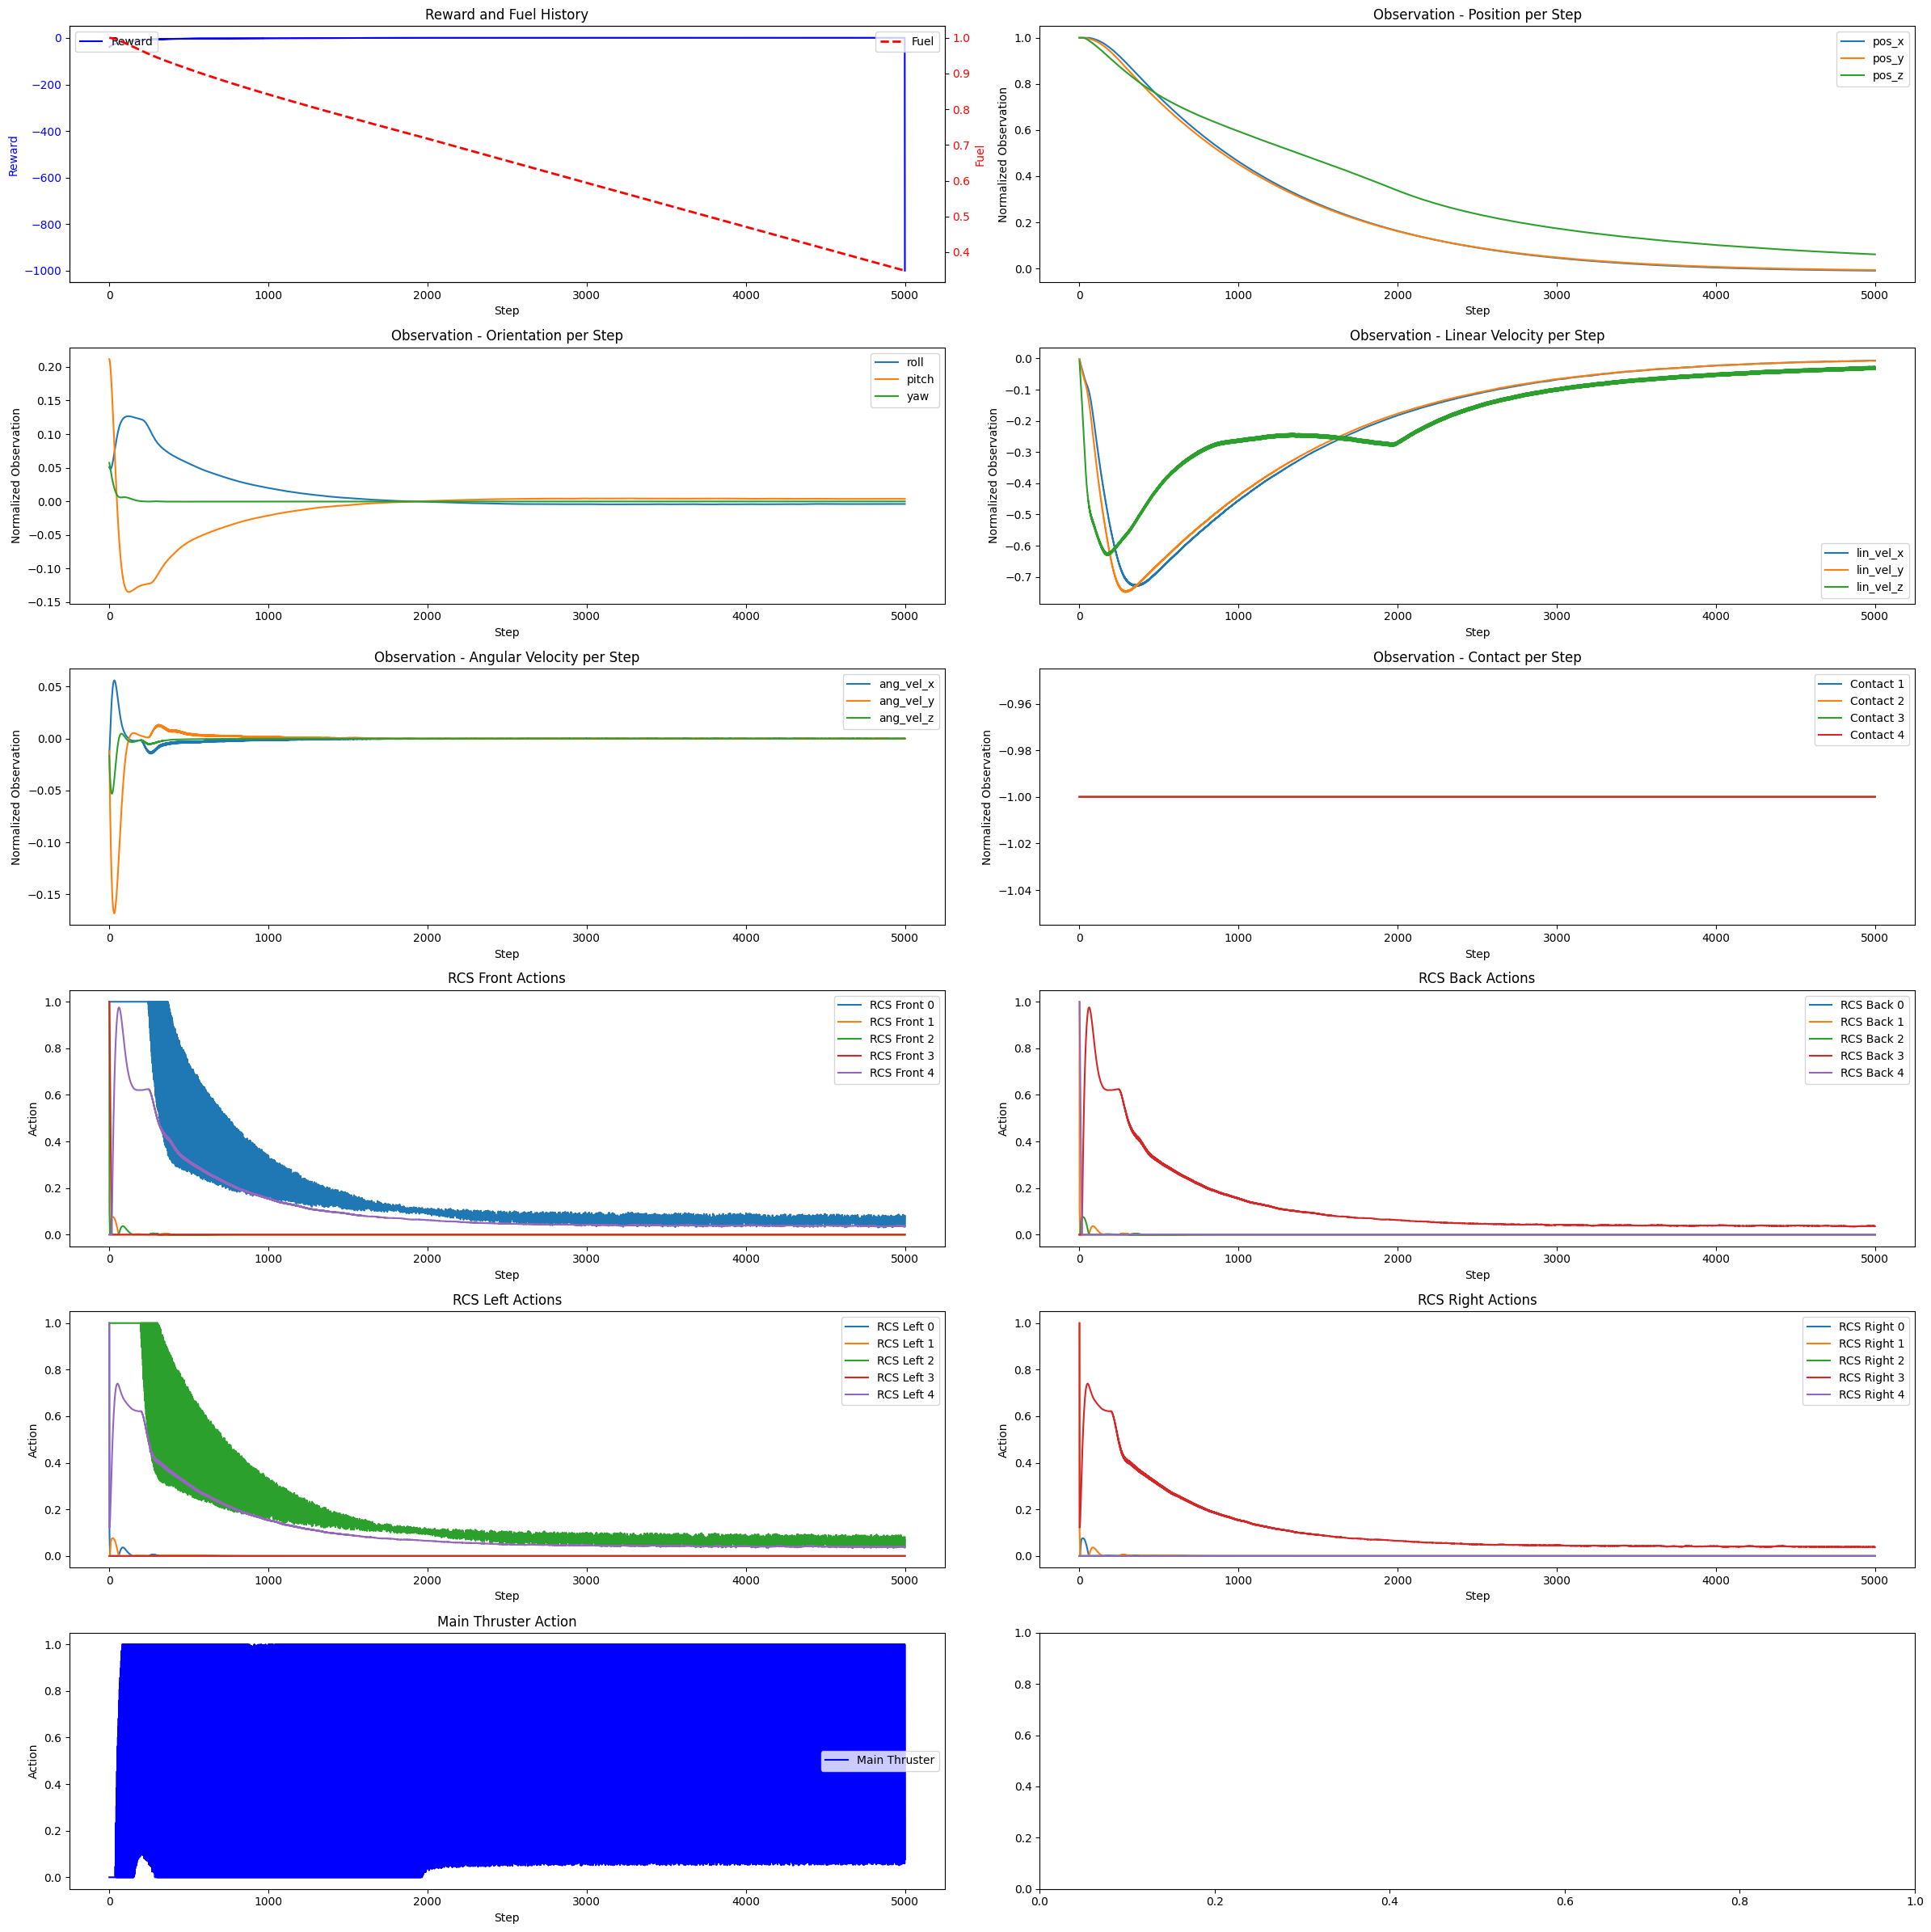

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import ttk
from LunarLander3DEnv.envs import LunarLander3DEnv  # Pastikan environment sudah tersedia
from gymnasium import spaces
import threading

########################################
# PID Controller Class
########################################

class PID:
    def __init__(self, kp, ki, kd, dt, integrator_limit=np.inf):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.dt = dt
        self.integrator = 0.0
        self.prev_error = 0.0
        self.integrator_limit = integrator_limit

    def update(self, error):
        p_term = self.kp * error
        self.integrator += error * self.dt
        self.integrator = np.clip(self.integrator, -self.integrator_limit, self.integrator_limit)
        i_term = self.ki * self.integrator
        d_term = self.kd * ((error - self.prev_error) / self.dt)
        prev_error = self.prev_error
        self.prev_error = error
        output = p_term + i_term + d_term
        return output, p_term, i_term, d_term, prev_error

########################################
# Combined Display (Tkinter GUI)
# Menampilkan Observations, Actions, dan PID dalam 3 kolom
########################################

class CombinedDisplay(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("Lunar Lander: PID, Observations & Actions")
        self.geometry("960x1080")
        
        # Buat tiga frame utama
        self.obs_frame = ttk.LabelFrame(self, text="Observations", padding=(10,10))
        self.obs_frame.grid(row=0, column=0, padx=10, pady=10, sticky="nsew")
        
        self.act_frame = ttk.LabelFrame(self, text="Actions", padding=(10,10))
        self.act_frame.grid(row=0, column=1, padx=10, pady=10, sticky="nsew")
        
        self.pid_frame = ttk.LabelFrame(self, text="PID Control", padding=(10,10))
        self.pid_frame.grid(row=0, column=2, padx=10, pady=10, sticky="nsew")
        
        self._create_obs_widgets()
        self._create_act_widgets()
        # Tambahkan parameter PID: untuk sikap (z, roll, pitch, yaw) dan kecepatan (vel_x, vel_y, vel_z)
        self._create_pid_widgets()
        
        self.grid_columnconfigure(0, weight=1)
        self.grid_columnconfigure(1, weight=1)
        self.grid_columnconfigure(2, weight=2)
    
    def _create_obs_widgets(self):
        self.obs_labels = {}
        obs_names = ["pos_x", "pos_y", "pos_z", "roll", "pitch", "yaw",
                     "lin_vel_x", "lin_vel_y", "lin_vel_z",
                     "ang_vel_x", "ang_vel_y", "ang_vel_z",
                     "fuel", "contact_1", "contact_2", "contact_3", "contact_4"]
        for i, name in enumerate(obs_names):
            ttk.Label(self.obs_frame, text=name, font=("Arial", 10)).grid(row=i, column=0, padx=5, pady=2, sticky="w")
            self.obs_labels[name] = ttk.Label(self.obs_frame, text="0.0000", font=("Arial", 10))
            self.obs_labels[name].grid(row=i, column=1, padx=5, pady=2, sticky="w")
    
    def _create_act_widgets(self):
        self.action_labels = {}
        for i in range(21):
            action_name = f"Action {i}"
            ttk.Label(self.act_frame, text=action_name, font=("Arial", 10)).grid(row=i, column=0, padx=5, pady=2, sticky="w")
            self.action_labels[action_name] = ttk.Label(self.act_frame, text="0.0000", font=("Arial", 10))
            self.action_labels[action_name].grid(row=i, column=1, padx=5, pady=2, sticky="w")
    
    def _create_pid_widgets(self):
        self.pid_labels = {}
        # Parameter untuk PID: kontrol sikap: z, roll, pitch, yaw; kontrol kecepatan: vel_x, vel_y, vel_z.
        parameters = ["roll", "pitch", "yaw", "vel_x", "vel_y", "vel_z"]
        components = ["PID Output", "Error", "Prev Error", "P", "I", "D"]
        
        for j, text in enumerate(["Control"] + components):
            ttk.Label(self.pid_frame, text=text, font=("Arial", 12, "bold")).grid(row=0, column=j, padx=5, pady=5)
        
        for i, param in enumerate(parameters):
            ttk.Label(self.pid_frame, text=param.upper(), font=("Arial", 12)).grid(row=i+1, column=0, padx=5, pady=5, sticky="w")
            for j, comp in enumerate(components):
                lbl = ttk.Label(self.pid_frame, text="0.0000", font=("Arial", 10))
                lbl.grid(row=i+1, column=j+1, padx=5, pady=5, sticky="w")
                self.pid_labels[f"{param}_{comp}"] = lbl
    
    def update_values(self, pid_data, obs, action):
        # Update Observations
        for key, val in zip(self.obs_labels.keys(), obs):
            self.obs_labels[key].config(text=f"{val:.4f}")
        
        # Update Actions
        for key, val in zip(self.action_labels.keys(), action):
            self.action_labels[key].config(text=f"{val:.4f}")
        
        # Update PID
        for key, value in pid_data.items():
            self.pid_labels[key].config(text=f"{value:.4f}")
        
        self.update()

########################################
# Lander PID Controller (21 Action Space)
########################################

class LanderPIDController:
    def __init__(self, dt, max_thrust, obs_min, obs_max):
        self.dt = dt
        self.max_thrust = max_thrust
        self.obs_min = obs_min
        self.obs_max = obs_max
        
        # PID untuk kecepatan linear
        self.x_vel_pid = PID(kp=5.0, ki=0.1, kd=1.0, dt=dt, integrator_limit=10)
        self.y_vel_pid = PID(kp=5.0, ki=0.1, kd=1.0, dt=dt, integrator_limit=10)
        self.z_vel_pid = PID(kp=5.0, ki=1.0, kd=1.0, dt=dt, integrator_limit=10)
        
        # PID untuk kontrol sikap (orientasi)
        self.pitch_pid = PID(kp=5.0, ki=0.1, kd=2.0, dt=dt, integrator_limit=10)
        self.roll_pid  = PID(kp=5.0, ki=0.1, kd=2.0, dt=dt, integrator_limit=10)
        self.yaw_pid   = PID(kp=5.0, ki=0.1, kd=2.0, dt=dt, integrator_limit=10)
    
    def denormalize(self, norm_obs):
        return self.obs_min + (norm_obs + 1.0) * (self.obs_max - self.obs_min) / 2.0

    def compute_action(self, norm_obs):
        pos = norm_obs[0:3]      # [x, y, z]
        orient = norm_obs[3:6]   # [roll, pitch, yaw]
        vel = norm_obs[6:9]      # Linear velocity
        
        # Target kecepatan: asumsikan target kecepatan adalah 1/10 dari negatif posisi
        target_vx = -pos[0] 
        target_vy = -pos[1] 
        target_vz = -pos[2] / 2
        
        
        error_vx = vel[0] - target_vx
        error_vy = vel[1] - target_vy
        error_vz = vel[2] - target_vz
        
        x_vel_command, p_xvel, i_xvel, d_xvel, prev_xvel = self.x_vel_pid.update(error_vx)
        y_vel_command, p_yvel, i_yvel, d_yvel, prev_yvel = self.y_vel_pid.update(error_vy)
        z_vel_command, p_zvel, i_zvel, d_zvel, prev_zvel = self.z_vel_pid.update(error_vz)
        
        # Kontrol sikap: target orientasi adalah 0
        
        roll_error  = orient[0]
        pitch_error = orient[1]
        yaw_error   = orient[2]
        
        pitch_correction, p_p, i_p, d_p, prev_pitch = self.pitch_pid.update(pitch_error)
        roll_correction, p_r, i_r, d_r, prev_roll = self.roll_pid.update(roll_error)
        yaw_correction, p_y, i_y, d_y, prev_yaw = self.yaw_pid.update(yaw_error)
        
        # Buat pid_data untuk GUI
        pid_data = {
            "pitch_PID Output": pitch_correction, "pitch_Error": pitch_error, "pitch_P": p_p, "pitch_I": i_p, "pitch_D": d_p,
            "roll_PID Output": roll_correction, "roll_Error": roll_error, "roll_P": p_r, "roll_I": i_r, "roll_D": d_r,
            "yaw_PID Output": yaw_correction, "yaw_Error": yaw_error, "yaw_P": p_y, "yaw_I": i_y, "yaw_D": d_y,
            "vel_x_PID Output": x_vel_command, "vel_x_Error": error_vx, "vel_x_P": p_xvel, "vel_x_I": i_xvel, "vel_x_D": d_xvel,
            "vel_y_PID Output": y_vel_command, "vel_y_Error": error_vy, "vel_y_P": p_yvel, "vel_y_I": i_yvel, "vel_y_D": d_yvel,
            "vel_z_PID Output": z_vel_command, "vel_z_Error": error_vz, "vel_z_P": p_zvel, "vel_z_I": i_zvel, "vel_z_D": d_zvel,
        }
        
        #Back -X | X Front
        #Right -Y | Y Left

        action = [
            #main
            -z_vel_command,
            
            # Front
            #-x, +y, -y, +z, -z
            x_vel_command,       #good
            -yaw_correction,     #good
            yaw_correction,      #good
            pitch_correction,    #good
            -pitch_correction,   #good

            #Back
            #+x, +y, -y, +z, -z
            -x_vel_command,      #good
            yaw_correction,      #good
            -yaw_correction,     #good
            -pitch_correction,   #good
            pitch_correction,    #good

            #Left
            #+x, -x, -y, +z, -z
            yaw_correction,      #good
            -yaw_correction,     #good
            y_vel_command,       #good
            -roll_correction,    #good
            roll_correction,     #good

            #Right
            #+x, -x, +y, +z, -z
            -yaw_correction,     #good
            yaw_correction,      #good
            -y_vel_command,      #good
            roll_correction,     #good
            -roll_correction     #good
            
        ]

        #action =[  0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

        
        action_vector = np.clip(action, 0, 1)
        
        return action_vector, pid_data

########################################
# Program Utama: Inferensi, GUI, dan Plotting
########################################
def run_gui():
    gui.mainloop()
gui = CombinedDisplay()
gui_thread = threading.Thread(target=run_gui, daemon=True)
gui_thread.start()

if __name__ == '__main__':
    env = LunarLander3DEnv(render_mode='human', start_position=[100, 100, 100], planet="earth")
    norm_obs, info = env.reset()
    dt = 1.0 / env.render_fps
    controller = LanderPIDController(dt, env.max_thrust, env.obs_min, env.obs_max)
    
    obs_history = []
    action_history = []
    reward_history = []
    fuel_history = []
    step_history = []
    
    done = False
    while not done:
        action, pid_data = controller.compute_action(norm_obs)
        
        norm_obs, reward, terminated, truncated, info = env.step(action)
        action_history.append(action.copy())
        obs_history.append(norm_obs.copy())
        reward_history.append(reward)
        fuel_history.append(norm_obs[12])
        step_history.append(env.step_counter)
        done = terminated or truncated
        # Perbarui GUI dengan PID, Observasi, dan Aksi
        gui.update_values(pid_data, norm_obs, action)
        env.render()
        # time.sleep(dt)
    env.close()
    
    obs_history = np.array(obs_history)
    action_history = np.array(action_history)
    reward_history = np.array(reward_history)
    fuel_history = np.array(fuel_history)
    step_history = np.array(step_history)
    
    # Plotting: Pisahkan grafik aksi menjadi 5 grafik
    fig, axs = plt.subplots(6, 2, figsize=(24, 24))
    
    # Plot 1: Reward dan Fuel over Steps
    ax = axs[0, 0]
    ax.plot(step_history, reward_history, 'b-', label='Reward')
    ax.set_xlabel('Step')
    ax.set_ylabel('Reward', color='b')
    ax.tick_params(axis='y', labelcolor='b')
    axb = ax.twinx()
    axb.plot(step_history, fuel_history, 'r--', label='Fuel', linewidth=2)
    axb.set_ylabel('Fuel', color='r')
    axb.tick_params(axis='y', labelcolor='r')
    ax.set_title('Reward and Fuel History')
    ax.legend(loc='upper left'), axb.legend(loc='upper right')
    
    # Plot 2: Observations - Position
    obs_labels_pos = ["pos_x", "pos_y", "pos_z"]
    obs_subset_pos = obs_history[:, 0:3]
    for i in range(obs_subset_pos.shape[1]):
        axs[0, 1].plot(step_history, obs_subset_pos[:, i], label=obs_labels_pos[i])
    axs[0, 1].set_xlabel('Step')
    axs[0, 1].set_ylabel('Normalized Observation')
    axs[0, 1].set_title('Observation - Position per Step')
    axs[0, 1].legend()
    
    # Plot 3: Observations - Orientation
    obs_labels_ori = ["roll", "pitch", "yaw"]
    obs_subset_ori = obs_history[:, 3:6]
    for i in range(obs_subset_ori.shape[1]):
        axs[1, 0].plot(step_history, obs_subset_ori[:, i], label=obs_labels_ori[i])
    axs[1, 0].set_xlabel('Step')
    axs[1, 0].set_ylabel('Normalized Observation')
    axs[1, 0].set_title('Observation - Orientation per Step')
    axs[1, 0].legend()
    
    # Plot 4: Observations - Linear Velocity
    obs_labels_lin_vel = ["lin_vel_x", "lin_vel_y", "lin_vel_z"]
    obs_subset_lin_vel = obs_history[:, 6:9]
    for i in range(obs_subset_lin_vel.shape[1]):
        axs[1, 1].plot(step_history, obs_subset_lin_vel[:, i], label=obs_labels_lin_vel[i])
    axs[1, 1].set_xlabel('Step')
    axs[1, 1].set_ylabel('Normalized Observation')
    axs[1, 1].set_title('Observation - Linear Velocity per Step')
    axs[1, 1].legend()
    
    # Plot 5: Observations - Angular Velocity
    obs_labels_ang_vel = ["ang_vel_x", "ang_vel_y", "ang_vel_z"]
    obs_subset_ang_vel = obs_history[:, 9:12]
    for i in range(obs_subset_ang_vel.shape[1]):
        axs[2, 0].plot(step_history, obs_subset_ang_vel[:, i], label=obs_labels_ang_vel[i])
    axs[2, 0].set_xlabel('Step')
    axs[2, 0].set_ylabel('Normalized Observation')
    axs[2, 0].set_title('Observation - Angular Velocity per Step')
    axs[2, 0].legend()
    
    # Plot 6: Observations - Contact Sensors
    contact_labels = ["Contact 1", "Contact 2", "Contact 3", "Contact 4"]
    obs_subset_contact = obs_history[:, 13:17]
    for i in range(obs_subset_contact.shape[1]):
        axs[2, 1].plot(step_history, obs_subset_contact[:, i], label=contact_labels[i])
    axs[2, 1].set_xlabel('Step')
    axs[2, 1].set_ylabel('Normalized Observation')
    axs[2, 1].set_title('Observation - Contact per Step')
    axs[2, 1].legend()
    
    # Plot 7: Action History (Pisahkan menjadi 5 grafik)
    main_thruster_actions = action_history[:, 0]
    rcs_front_actions = action_history[:, 1:6]
    rcs_back_actions = action_history[:, 6:11]
    rcs_left_actions = action_history[:, 11:16]
    rcs_right_actions = action_history[:, 16:21]

    

    for i in range(rcs_front_actions.shape[1]):
        axs[3, 0].plot(step_history, rcs_front_actions[:, i], label=f'RCS Front {i}')
    axs[3, 0].set_xlabel("Step") 
    axs[3, 0].set_ylabel("Action")
    axs[3, 0].set_title("RCS Front Actions")
    axs[3, 0].legend()
    
    for i in range(rcs_back_actions.shape[1]):
        axs[3, 1].plot(step_history, rcs_back_actions[:, i], label=f'RCS Back {i}')
    axs[3, 1].set_xlabel("Step")
    axs[3, 1].set_ylabel("Action")
    axs[3, 1].set_title("RCS Back Actions")
    axs[3, 1].legend()
    
    for i in range(rcs_left_actions.shape[1]):
        axs[4, 0].plot(step_history, rcs_left_actions[:, i], label=f'RCS Left {i}')
    axs[4, 0].set_xlabel("Step")
    axs[4, 0].set_ylabel("Action")
    axs[4, 0].set_title("RCS Left Actions")
    axs[4, 0].legend()
    
    for i in range(rcs_right_actions.shape[1]):
        axs[4, 1].plot(step_history, rcs_right_actions[:, i], label=f'RCS Right {i}')
    axs[4, 1].set_xlabel("Step")
    axs[4, 1].set_ylabel("Action")
    axs[4, 1].set_title("RCS Right Actions")
    axs[4, 1].legend()
    

    axs[5, 0].plot(step_history, main_thruster_actions, label="Main Thruster", color='blue')
    axs[5, 0].set_xlabel("Step") 
    axs[5, 0].set_ylabel("Action")
    axs[5, 0].set_title("Main Thruster Action")
    axs[5, 0].legend()

    plt.tight_layout()
    plt.show()


SELESAI
REWARD : -6696.913070446602


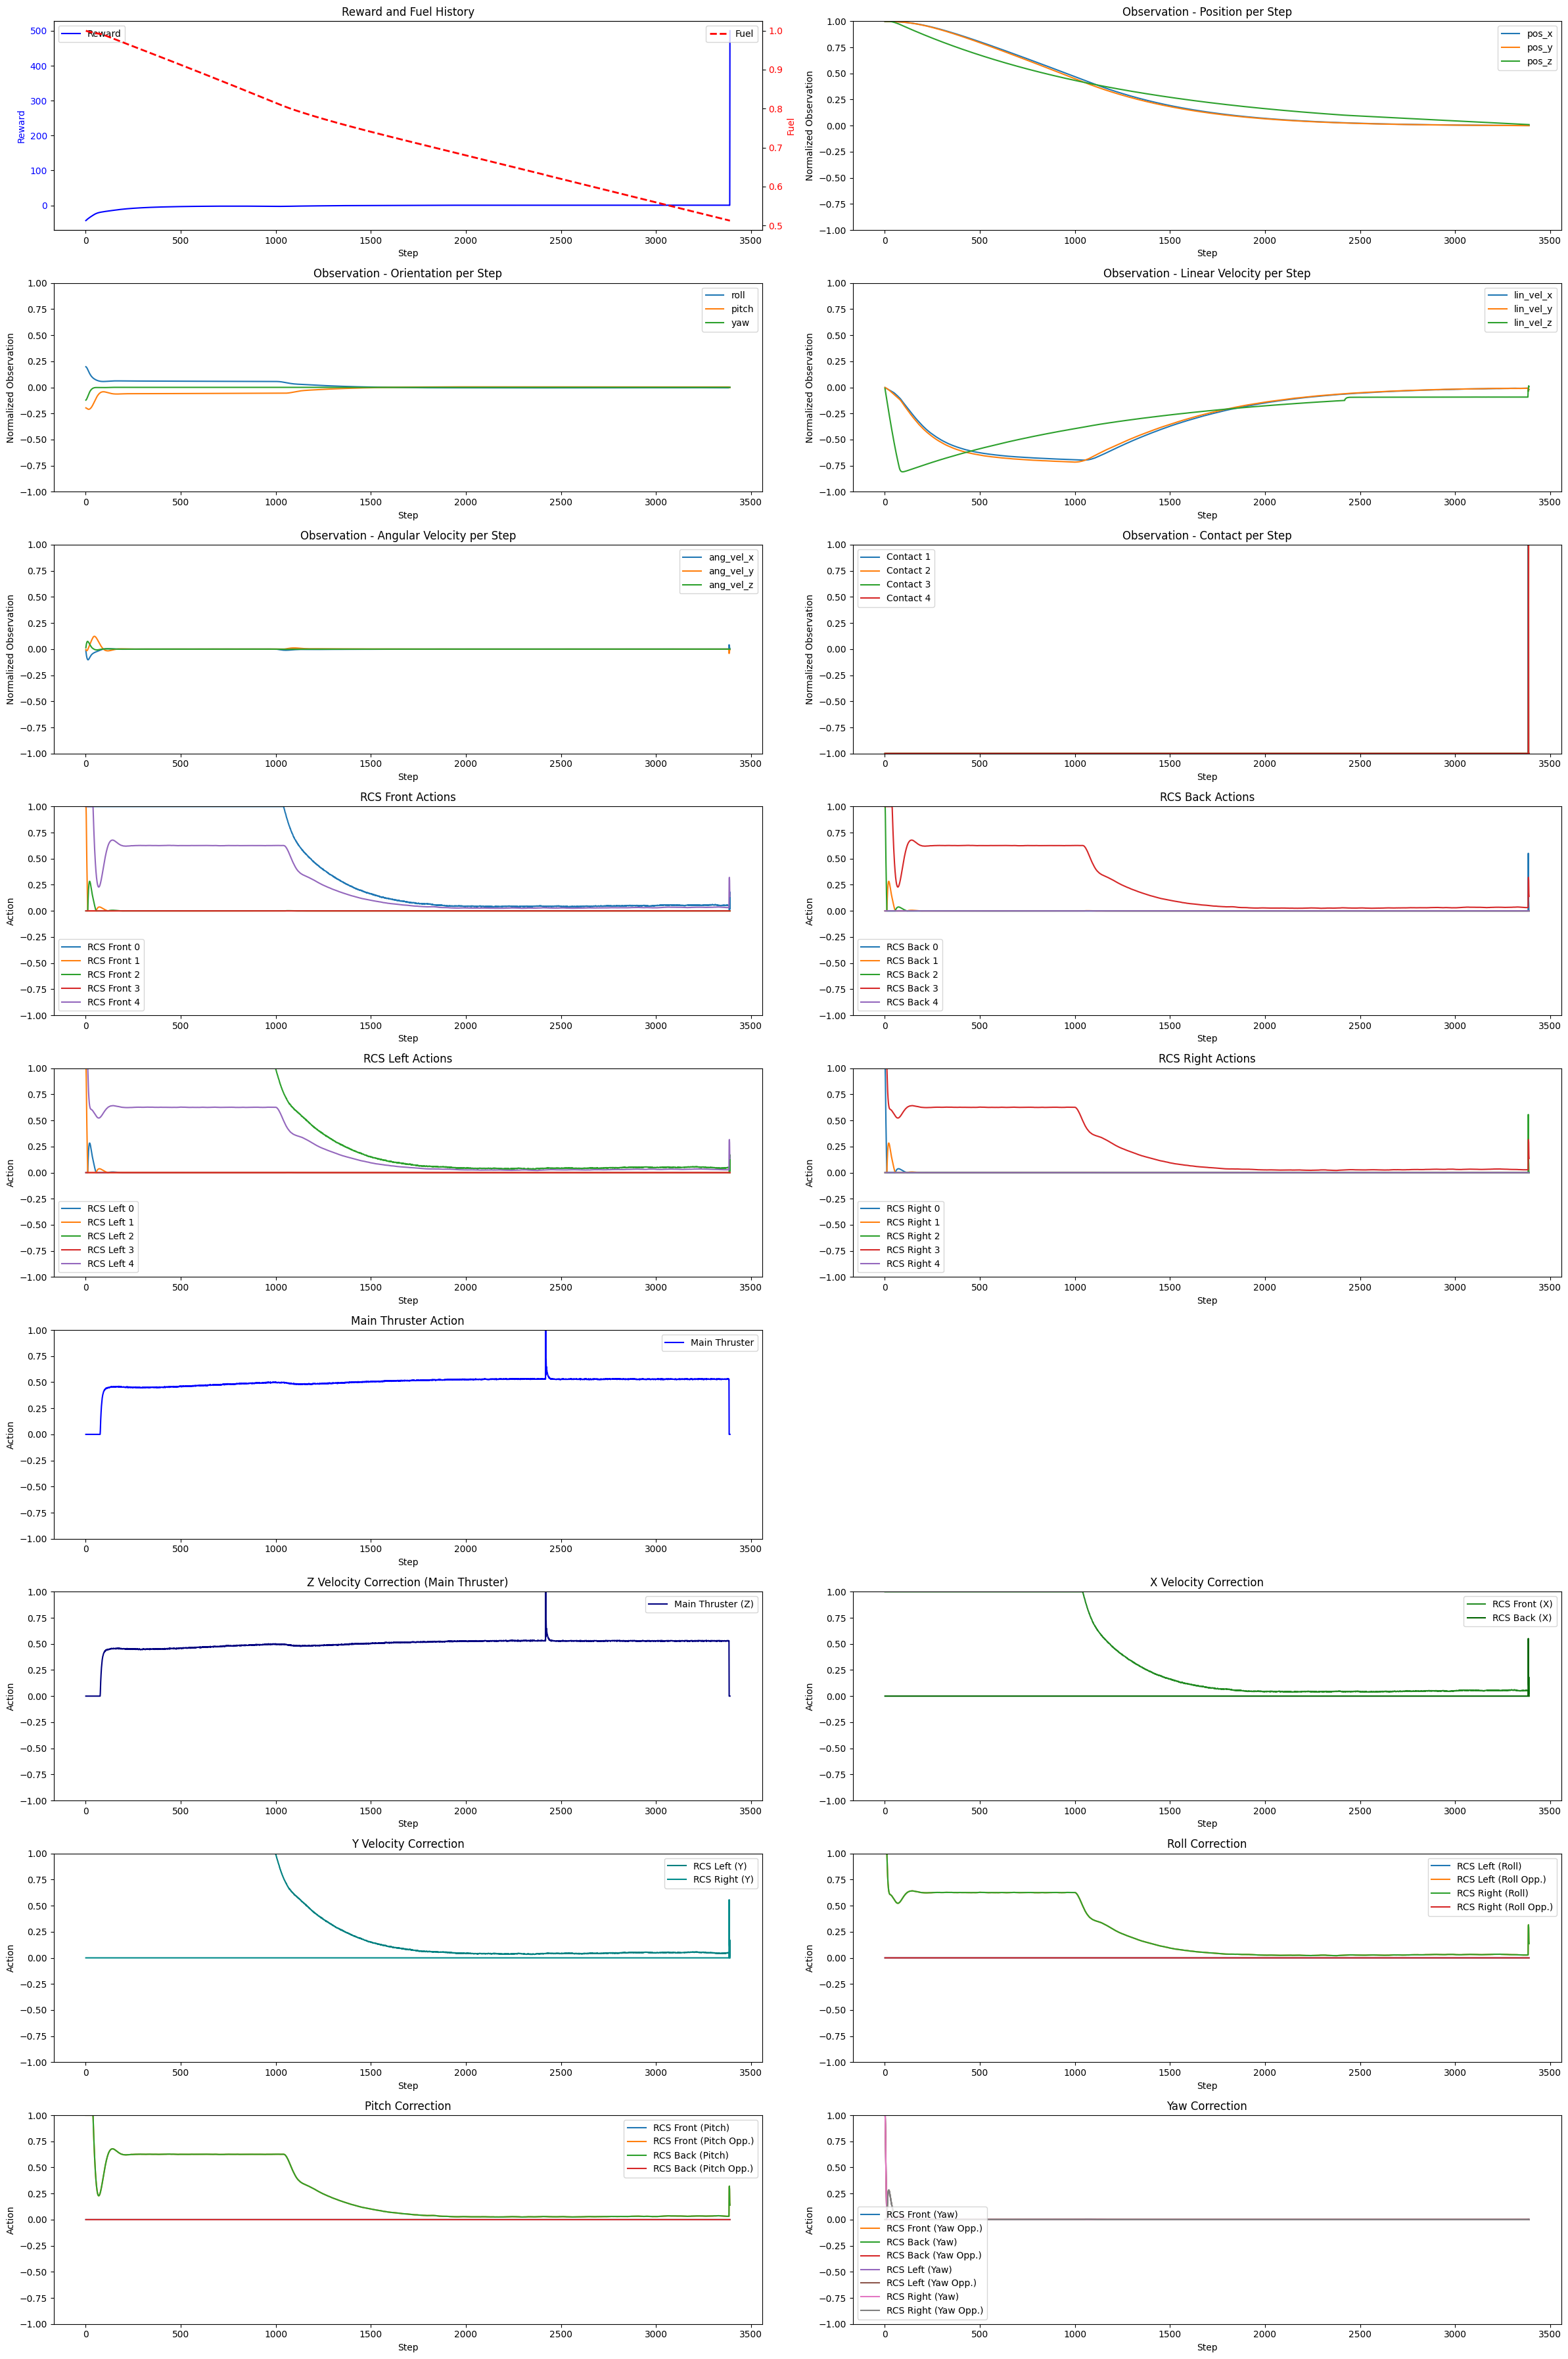

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import ttk
from LunarLander3DEnv.envs import LunarLander3DEnv  # Pastikan environment sudah tersedia
from gymnasium import spaces
import threading

########################################
# PID Controller Class
########################################

class PID:
    def __init__(self, kp, ki, kd, dt, integrator_limit=np.inf):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.dt = dt
        self.integrator = 0.0
        self.prev_error = 0.0
        self.integrator_limit = integrator_limit

    def update(self, error):
        p_term = self.kp * error
        self.integrator += error * self.dt
        self.integrator = np.clip(self.integrator, -self.integrator_limit, self.integrator_limit)
        i_term = self.ki * self.integrator
        d_term = self.kd * ((error - self.prev_error) / self.dt)
        prev_error = self.prev_error
        self.prev_error = error
        output = p_term + i_term + d_term
        return output, p_term, i_term, d_term, prev_error

################################################################################
# Combined Display (Tkinter GUI)
# Menampilkan Observations, Actions, dan PID dalam 3 kolom
################################################################################

class CombinedDisplay(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("Lunar Lander: PID, Observations & Actions")
        self.geometry("960x1080")
        
        # Buat tiga frame utama
        self.obs_frame = ttk.LabelFrame(self, text="Observations", padding=(10,10))
        self.obs_frame.grid(row=0, column=0, padx=10, pady=10, sticky="nsew")
        
        self.act_frame = ttk.LabelFrame(self, text="Actions", padding=(10,10))
        self.act_frame.grid(row=0, column=1, padx=10, pady=10, sticky="nsew")
        
        self.pid_frame = ttk.LabelFrame(self, text="PID Control", padding=(10,10))
        self.pid_frame.grid(row=0, column=2, padx=10, pady=10, sticky="nsew")
        
        self._create_obs_widgets()
        self._create_act_widgets()
        self._create_pid_widgets()
        
        self.grid_columnconfigure(0, weight=1)
        self.grid_columnconfigure(1, weight=1)
        self.grid_columnconfigure(2, weight=2)
    
    def _create_obs_widgets(self):
        self.obs_labels = {}
        obs_names = ["pos_x", "pos_y", "pos_z", "roll", "pitch", "yaw",
                     "lin_vel_x", "lin_vel_y", "lin_vel_z",
                     "ang_vel_x", "ang_vel_y", "ang_vel_z",
                     "fuel", "contact_1", "contact_2", "contact_3", "contact_4"]
        for i, name in enumerate(obs_names):
            ttk.Label(self.obs_frame, text=name, font=("Arial", 10)).grid(row=i, column=0, padx=5, pady=2, sticky="w")
            self.obs_labels[name] = ttk.Label(self.obs_frame, text="0.0000", font=("Arial", 10))
            self.obs_labels[name].grid(row=i, column=1, padx=5, pady=2, sticky="w")
    
    def _create_act_widgets(self):
        self.action_labels = {}
        for i in range(21):
            action_name = f"Action {i}"
            ttk.Label(self.act_frame, text=action_name, font=("Arial", 10)).grid(row=i, column=0, padx=5, pady=2, sticky="w")
            self.action_labels[action_name] = ttk.Label(self.act_frame, text="0.0000", font=("Arial", 10))
            self.action_labels[action_name].grid(row=i, column=1, padx=5, pady=2, sticky="w")
    
    def _create_pid_widgets(self):
        self.pid_labels = {}
        header = ["Control", "Target", "PID Output", "Error", "Prev Error", "P", "I", "D"]
        for j, text in enumerate(header):
            ttk.Label(self.pid_frame, text=text, font=("Arial", 10)).grid(row=0, column=j, padx=5, pady=5)
        
        parameters = ["roll", "pitch", "yaw", "vel_x", "vel_y", "vel_z"]
        for i, param in enumerate(parameters):
            ttk.Label(self.pid_frame, text=param.upper(), font=("Arial", 10)).grid(row=i+1, column=0, padx=5, pady=5, sticky="w")
            for j, comp in enumerate(header[1:]):  # Mulai dari kolom Target
                lbl = ttk.Label(self.pid_frame, text="0.0000", font=("Arial", 10))
                lbl.grid(row=i+1, column=j+1, padx=5, pady=5, sticky="w")
                self.pid_labels[f"{param}_{comp}"] = lbl
    
    def update_values(self, pid_data, obs, action):
        # Jika obs memiliki 34 elemen, gunakan 17 elemen pertama sebagai current observation
        if len(obs) == 34:
            current_obs = obs[:17]
        else:
            current_obs = obs

        # Update Observations
        for key, val in zip(self.obs_labels.keys(), current_obs):
            self.obs_labels[key].config(text=f"{val:.4f}")

        # Update Actions
        for key, val in zip(self.action_labels.keys(), action):
            self.action_labels[key].config(text=f"{val:.4f}")

        # Update PID data
        for key, value in pid_data.items():
            if key in self.pid_labels:
                self.pid_labels[key].config(text=f"{value:.4f}")
        
        self.update_idletasks()

################################################################################
# Lander PID Controller (21 Action Space)
################################################################################

class LanderPIDController:
    def __init__(self, dt, max_thrust, obs_min, obs_max):
        self.dt = dt
        self.max_thrust = max_thrust
        self.obs_min = obs_min
        self.obs_max = obs_max
        
        # PID untuk kecepatan linear
        self.x_vel_pid = PID(kp=5.0, ki=0.1, kd=0.2, dt=dt, integrator_limit=1)
        self.y_vel_pid = PID(kp=5.0, ki=0.1, kd=0.2, dt=dt, integrator_limit=1)
        self.z_vel_pid = PID(kp=10.0, ki=0.1, kd=0.2, dt=dt, integrator_limit=1)
        
        # PID untuk kontrol sikap (orientasi)
        self.pitch_pid = PID(kp=10.0, ki=0.1, kd=2.0, dt=dt, integrator_limit=1)
        self.roll_pid  = PID(kp=10.0, ki=0.1, kd=2.0, dt=dt, integrator_limit=1)
        self.yaw_pid   = PID(kp=10.0, ki=0.1, kd=2.0, dt=dt, integrator_limit=1)
    
    def denormalize(self, norm_obs):
        return self.obs_min + (norm_obs + 1.0) * (self.obs_max - self.obs_min) / 2.0

    def compute_action(self, norm_obs):
        # Jika norm_obs berukuran 34, ambil current observation (17 elemen pertama)
        if len(norm_obs) == 34:
            norm_obs = norm_obs[:17]
        
        pos = norm_obs[0:3]      # [x, y, z]
        orient = norm_obs[3:6]   # [roll, pitch, yaw]
        vel = norm_obs[6:9]      # Linear velocity
        
        # Tentukan target kecepatan: target = -posisi (dengan skala)
        target_vx = -pos[0] * 2
        target_vy = -pos[1] * 2
        target_vz = -pos[2] * 0.8
        if pos[2] <= 0.1:
            target_vz = -0.05
        
        error_vx = vel[0] - target_vx
        error_vy = vel[1] - target_vy
        error_vz = vel[2] - target_vz
        
        x_vel_command, p_xvel, i_xvel, d_xvel, prev_xvel = self.x_vel_pid.update(error_vx)
        y_vel_command, p_yvel, i_yvel, d_yvel, prev_yvel = self.y_vel_pid.update(error_vy)
        z_vel_command, p_zvel, i_zvel, d_zvel, prev_zvel = self.z_vel_pid.update(error_vz)
        
        # Untuk kontrol sikap: target orientasi = 0
        roll_target = 0.0
        pitch_target = 0.0
        yaw_target = 0.0
        
        roll_error  = orient[0] - roll_target
        pitch_error = orient[1] - pitch_target
        yaw_error   = orient[2] - yaw_target
        
        roll_correction, p_r, i_r, d_r, prev_roll = self.roll_pid.update(roll_error)
        pitch_correction, p_p, i_p, d_p, prev_pitch = self.pitch_pid.update(pitch_error)
        yaw_correction, p_y, i_y, d_y, prev_yaw = self.yaw_pid.update(yaw_error)
        
        pid_data = {
            "pitch_Target": pitch_target,
            "pitch_PID Output": pitch_correction,
            "pitch_Error": pitch_error,
            "pitch_Prev Error": prev_pitch,
            "pitch_P": p_p,
            "pitch_I": i_p,
            "pitch_D": d_p,
            "roll_Target": roll_target,
            "roll_PID Output": roll_correction,
            "roll_Error": roll_error,
            "roll_Prev Error": prev_roll,
            "roll_P": p_r,
            "roll_I": i_r,
            "roll_D": d_r,
            "yaw_Target": yaw_target,
            "yaw_PID Output": yaw_correction,
            "yaw_Error": yaw_error,
            "yaw_Prev Error": prev_yaw,
            "yaw_P": p_y,
            "yaw_I": i_y,
            "yaw_D": d_y,
            "vel_x_Target": target_vx,
            "vel_x_PID Output": x_vel_command,
            "vel_x_Error": error_vx,
            "vel_x_Prev Error": prev_xvel,
            "vel_x_P": p_xvel,
            "vel_x_I": i_xvel,
            "vel_x_D": d_xvel,
            "vel_y_Target": target_vy,
            "vel_y_PID Output": y_vel_command,
            "vel_y_Error": error_vy,
            "vel_y_Prev Error": prev_yvel,
            "vel_y_P": p_yvel,
            "vel_y_I": i_yvel,
            "vel_y_D": d_yvel,
            "vel_z_Target": target_vz,
            "vel_z_PID Output": z_vel_command,
            "vel_z_Error": error_vz,
            "vel_z_Prev Error": prev_zvel,
            "vel_z_P": p_zvel,
            "vel_z_I": i_zvel,
            "vel_z_D": d_zvel,
        }
        
        # Definisikan aksi untuk 21 aktuator (contoh sederhana)
        action = [
            -z_vel_command,      # Main thruster: gunakan -z_vel_command
            x_vel_command,       # RCS Front
            -yaw_correction,
            yaw_correction,
            pitch_correction,
            -pitch_correction,
            -x_vel_command,      # RCS Back
            yaw_correction,
            -yaw_correction,
            -pitch_correction,
            pitch_correction,
            yaw_correction,      # RCS Left
            -yaw_correction,
            y_vel_command,
            -roll_correction,
            roll_correction,
            -yaw_correction,     # RCS Right
            yaw_correction,
            -y_vel_command,
            roll_correction,
            -roll_correction
        ]
        action_vector = np.clip(action, 0, 1)
        return action_vector, pid_data

################################################################################
# Program Utama: Simulasi, GUI, dan Plotting
################################################################################

import matplotlib.pyplot as plt
import threading

def simulation_loop(env, controller, gui, dt, results):
    obs_list = []
    action_list = []
    reward_list = []
    fuel_list = []
    step_list = []
    
    norm_obs, info = env.reset()
    done = False
    while not done:
        # Gunakan current observation (17 elemen pertama)
        action, pid_data = controller.compute_action(norm_obs)
        
        norm_obs, reward, terminated, truncated, info = env.step(action)
        action_list.append(np.array(action))
        obs_list.append(norm_obs.copy())
        reward_list.append(reward)
        # Fuel ada di current observation (indeks 12)
        fuel_list.append(norm_obs[12])
        step_list.append(env.step_counter)
        done = terminated or truncated
        
        # Update GUI secara thread-safe menggunakan .after()
        gui.after(0, gui.update_values, pid_data, norm_obs, action)
        env.render()
    
    env.close()
    print("SELESAI")
    results['obs'] = np.array(obs_list)
    results['action'] = np.array(action_list)
    results['reward'] = np.array(reward_list)
    results['fuel'] = np.array(fuel_list)
    results['step'] = np.array(step_list)
    gui.after(0, gui.destroy)
    
if __name__ == '__main__':
    env = LunarLander3DEnv(render_mode='human', start_position=[100, 100, 100], planet="earth")
    dt = 1.0 / env.render_fps
    env.difficulty = 1
    norm_obs, info = env.reset()
    controller = LanderPIDController(dt, env.max_thrust, env.obs_min, env.obs_max)
    
    gui = CombinedDisplay()
    
    results = {}
    sim_thread = threading.Thread(target=simulation_loop, args=(env, controller, gui, dt, results), daemon=True)
    sim_thread.start()
    
    gui.mainloop()   
    # Setelah GUI ditutup, lakukan plotting (jika simulasi telah selesai)
    print(f"REWARD : {results['reward'].sum()}")
    if results:
        obs_history = results['obs']
        action_history = results['action']
        reward_history = results['reward']
        fuel_history = results['fuel']
        step_history = results['step']
                        
        # Ubah layout subplot menjadi 9 baris x 2 kolom
        fig, axs = plt.subplots(9, 2, figsize=(24, 36))
                        
        # --- Baris 0: Reward & Observations ---
        # Baris 0, Kolom 0: Plot Reward dan Fuel over Steps
        ax = axs[0, 0]
        ax.plot(step_history, reward_history, 'b-', label='Reward')
        ax.set_xlabel('Step')
        ax.set_ylabel('Reward', color='b')
        ax.tick_params(axis='y', labelcolor='b')
        axb = ax.twinx()
        axb.plot(step_history, fuel_history, 'r--', label='Fuel', linewidth=2)
        axb.set_ylabel('Fuel', color='r')
        axb.tick_params(axis='y', labelcolor='r')
        ax.set_title('Reward and Fuel History')
        ax.legend(loc='upper left')
        axb.legend(loc='upper right')
        
        # Baris 0, Kolom 1: Observations - Position
        obs_labels_pos = ["pos_x", "pos_y", "pos_z"]
        obs_subset_pos = obs_history[:, 0:3]
        ax = axs[0, 1]
        for i in range(obs_subset_pos.shape[1]):
                ax.plot(step_history, obs_subset_pos[:, i], label=obs_labels_pos[i])
        ax.set_xlabel('Step')
        ax.set_ylabel('Normalized Observation')
        ax.set_title('Observation - Position per Step')
        ax.set_ylim(-1, 1) , ax.legend()
        
        # --- Baris 1: Observations ---
        # Baris 1, Kolom 0: Observations - Orientation
        obs_labels_ori = ["roll", "pitch", "yaw"]
        obs_subset_ori = obs_history[:, 3:6]
        ax = axs[1, 0]
        for i in range(obs_subset_ori.shape[1]):
                ax.plot(step_history, obs_subset_ori[:, i], label=obs_labels_ori[i])
        ax.set_xlabel('Step')
        ax.set_ylabel('Normalized Observation')
        ax.set_title('Observation - Orientation per Step')
        ax.set_ylim(-1, 1) , ax.legend()
        
        # Baris 1, Kolom 1: Observations - Linear Velocity
        obs_labels_lin_vel = ["lin_vel_x", "lin_vel_y", "lin_vel_z"]
        obs_subset_lin_vel = obs_history[:, 6:9]
        ax = axs[1, 1]
        for i in range(obs_subset_lin_vel.shape[1]):
                ax.plot(step_history, obs_subset_lin_vel[:, i], label=obs_labels_lin_vel[i])
        ax.set_xlabel('Step')
        ax.set_ylabel('Normalized Observation')
        ax.set_title('Observation - Linear Velocity per Step')
        ax.set_ylim(-1, 1) , ax.legend()
        
        # --- Baris 2: Observations ---
        # Baris 2, Kolom 0: Observations - Angular Velocity
        obs_labels_ang_vel = ["ang_vel_x", "ang_vel_y", "ang_vel_z"]
        obs_subset_ang_vel = obs_history[:, 9:12]
        ax = axs[2, 0]
        for i in range(obs_subset_ang_vel.shape[1]):
                ax.plot(step_history, obs_subset_ang_vel[:, i], label=obs_labels_ang_vel[i])
        ax.set_xlabel('Step')
        ax.set_ylabel('Normalized Observation')
        ax.set_title('Observation - Angular Velocity per Step')
        ax.set_ylim(-1, 1) , ax.legend()
        
        # Baris 2, Kolom 1: Observations - Contact Sensors
        contact_labels = ["Contact 1", "Contact 2", "Contact 3", "Contact 4"]
        obs_subset_contact = obs_history[:, 13:17]
        ax = axs[2, 1]
        for i in range(obs_subset_contact.shape[1]):
                ax.plot(step_history, obs_subset_contact[:, i], label=contact_labels[i])
        ax.set_xlabel('Step')
        ax.set_ylabel('Normalized Observation')
        ax.set_title('Observation - Contact per Step')
        ax.set_ylim(-1, 1) , ax.legend()
        
        # --- Baris 3 & 4: Aksi Berdasarkan Grup RCS (asli) ---
        # Baris 3, Kolom 0: Action History - RCS Front
        rcs_front_actions = action_history[:, 1:6]
        ax = axs[3, 0]
        for i in range(rcs_front_actions.shape[1]):
                ax.plot(step_history, rcs_front_actions[:, i], label=f'RCS Front {i}')
        ax.set_xlabel("Step")
        ax.set_ylabel("Action")
        ax.set_title("RCS Front Actions")
        ax.set_ylim(-1, 1) , ax.legend()
        
        # Baris 3, Kolom 1: Action History - RCS Back
        rcs_back_actions = action_history[:, 6:11]
        ax = axs[3, 1]
        for i in range(rcs_back_actions.shape[1]):
                ax.plot(step_history, rcs_back_actions[:, i], label=f'RCS Back {i}')
        ax.set_xlabel("Step")
        ax.set_ylabel("Action")
        ax.set_title("RCS Back Actions")
        ax.set_ylim(-1, 1) , ax.legend()
        
        # Baris 4, Kolom 0: Action History - RCS Left
        rcs_left_actions = action_history[:, 11:16]
        ax = axs[4, 0]
        for i in range(rcs_left_actions.shape[1]):
                ax.plot(step_history, rcs_left_actions[:, i], label=f'RCS Left {i}')
        ax.set_xlabel("Step")
        ax.set_ylabel("Action")
        ax.set_title("RCS Left Actions")
        ax.set_ylim(-1, 1) , ax.legend()
        
        # Baris 4, Kolom 1: Action History - RCS Right
        rcs_right_actions = action_history[:, 16:21]
        ax = axs[4, 1]
        for i in range(rcs_right_actions.shape[1]):
                ax.plot(step_history, rcs_right_actions[:, i], label=f'RCS Right {i}')
        ax.set_xlabel("Step")
        ax.set_ylabel("Action")
        ax.set_title("RCS Right Actions")
        ax.set_ylim(-1, 1) , ax.legend()
        
        # Baris 5, Kolom 0: Main Thruster Action
        main_thruster_actions = action_history[:, 0]
        ax = axs[5, 0]
        ax.plot(step_history, main_thruster_actions, label="Main Thruster", color='blue')
        ax.set_xlabel("Step")
        ax.set_ylabel("Action")
        ax.set_title("Main Thruster Action")
        ax.set_ylim(-1, 1) , ax.legend()
        
        # Baris 5, Kolom 1: Kosongkan (atau gunakan untuk informasi lain)
        axs[5, 1].axis('off')
        
        # --- Baris 6-8: Grafik Berdasarkan Sinyal Kontrol (aksi per actuator) ---
        # Urutannya: Z Velocity Correction, X Velocity Correction, Y Velocity Correction, Roll Correction, Pitch Correction, Yaw Correction.
        
        # Baris 6, Kolom 0: Z Velocity Correction (Main Thruster)
        ax = axs[6, 0]
        ax.plot(step_history, action_history[:, 0], label="Main Thruster (Z)", color='navy')
        ax.set_xlabel("Step")
        ax.set_ylabel("Action")
        ax.set_title("Z Velocity Correction (Main Thruster)")
        ax.set_ylim(-1, 1) , ax.legend()
        
        # Baris 6, Kolom 1: X Velocity Correction (RCS depan & belakang)
        ax = axs[6, 1]
        ax.plot(step_history, action_history[:, 1], label="RCS Front (X)", color='forestgreen')
        ax.plot(step_history, action_history[:, 6], label="RCS Back (X)", color='darkgreen')
        ax.set_xlabel("Step")
        ax.set_ylabel("Action")
        ax.set_title("X Velocity Correction")
        ax.set_ylim(-1, 1) , ax.legend()
        
        # Baris 7, Kolom 0: Y Velocity Correction (RCS kiri & kanan)
        ax = axs[7, 0]
        ax.plot(step_history, action_history[:, 13], label="RCS Left (Y)", color='teal')
        ax.plot(step_history, action_history[:, 18], label="RCS Right (Y)", color='darkcyan',)
        ax.set_xlabel("Step")
        ax.set_ylabel("Action")
        ax.set_title("Y Velocity Correction")
        ax.set_ylim(-1, 1) , ax.legend()
        
        # Baris 7, Kolom 1: Roll Correction (misalnya, ambil dua actuator dari grup kanan)
        ax = axs[7, 1]
        
        ax.plot(step_history, action_history[:, 14], label="RCS Left (Roll)",)
        ax.plot(step_history, action_history[:, 15], label="RCS Left (Roll Opp.)", )
        ax.plot(step_history, action_history[:, 19], label="RCS Right (Roll)", )
        ax.plot(step_history, action_history[:, 20], label="RCS Right (Roll Opp.)",)
        ax.set_xlabel("Step")
        ax.set_ylabel("Action")
        ax.set_title("Roll Correction")
        ax.set_ylim(-1, 1) , ax.legend()
        
        # Baris 8, Kolom 0: Pitch Correction (misalnya, ambil actuator dari grup depan dan belakang)
        ax = axs[8, 0]
        
        ax.plot(step_history, action_history[:, 4], label="RCS Front (Pitch)",)
        ax.plot(step_history, action_history[:, 5], label="RCS Front (Pitch Opp.)",)
        ax.plot(step_history, action_history[:, 9], label="RCS Back (Pitch)",)
        ax.plot(step_history, action_history[:, 10], label="RCS Back (Pitch Opp.)",)
        ax.set_xlabel("Step")
        ax.set_ylabel("Action")
        ax.set_title("Pitch Correction")
        ax.set_ylim(-1, 1) , ax.legend()
        
        # Baris 8, Kolom 1: Yaw Correction (misalnya, ambil actuator dari grup depan dan belakang)
        ax = axs[8, 1]
        ax.plot(step_history, action_history[:, 2], label="RCS Front (Yaw)",)
        ax.plot(step_history, action_history[:, 3], label="RCS Front (Yaw Opp.)",)
        ax.plot(step_history, action_history[:, 7], label="RCS Back (Yaw)",)
        ax.plot(step_history, action_history[:, 8], label="RCS Back (Yaw Opp.)",)
        ax.plot(step_history, action_history[:, 11], label="RCS Left (Yaw)",)
        ax.plot(step_history, action_history[:, 12], label="RCS Left (Yaw Opp.)",)
        ax.plot(step_history, action_history[:, 16], label="RCS Right (Yaw)",)
        ax.plot(step_history, action_history[:, 17], label="RCS Right (Yaw Opp.)",)
        ax.set_xlabel("Step")
        ax.set_ylabel("Action")
        ax.set_title("Yaw Correction")
        ax.set_ylim(-1, 1) , ax.legend()
        
        plt.tight_layout()
        plt.show()


SELESAI
REWARD : -1450.9367029255725


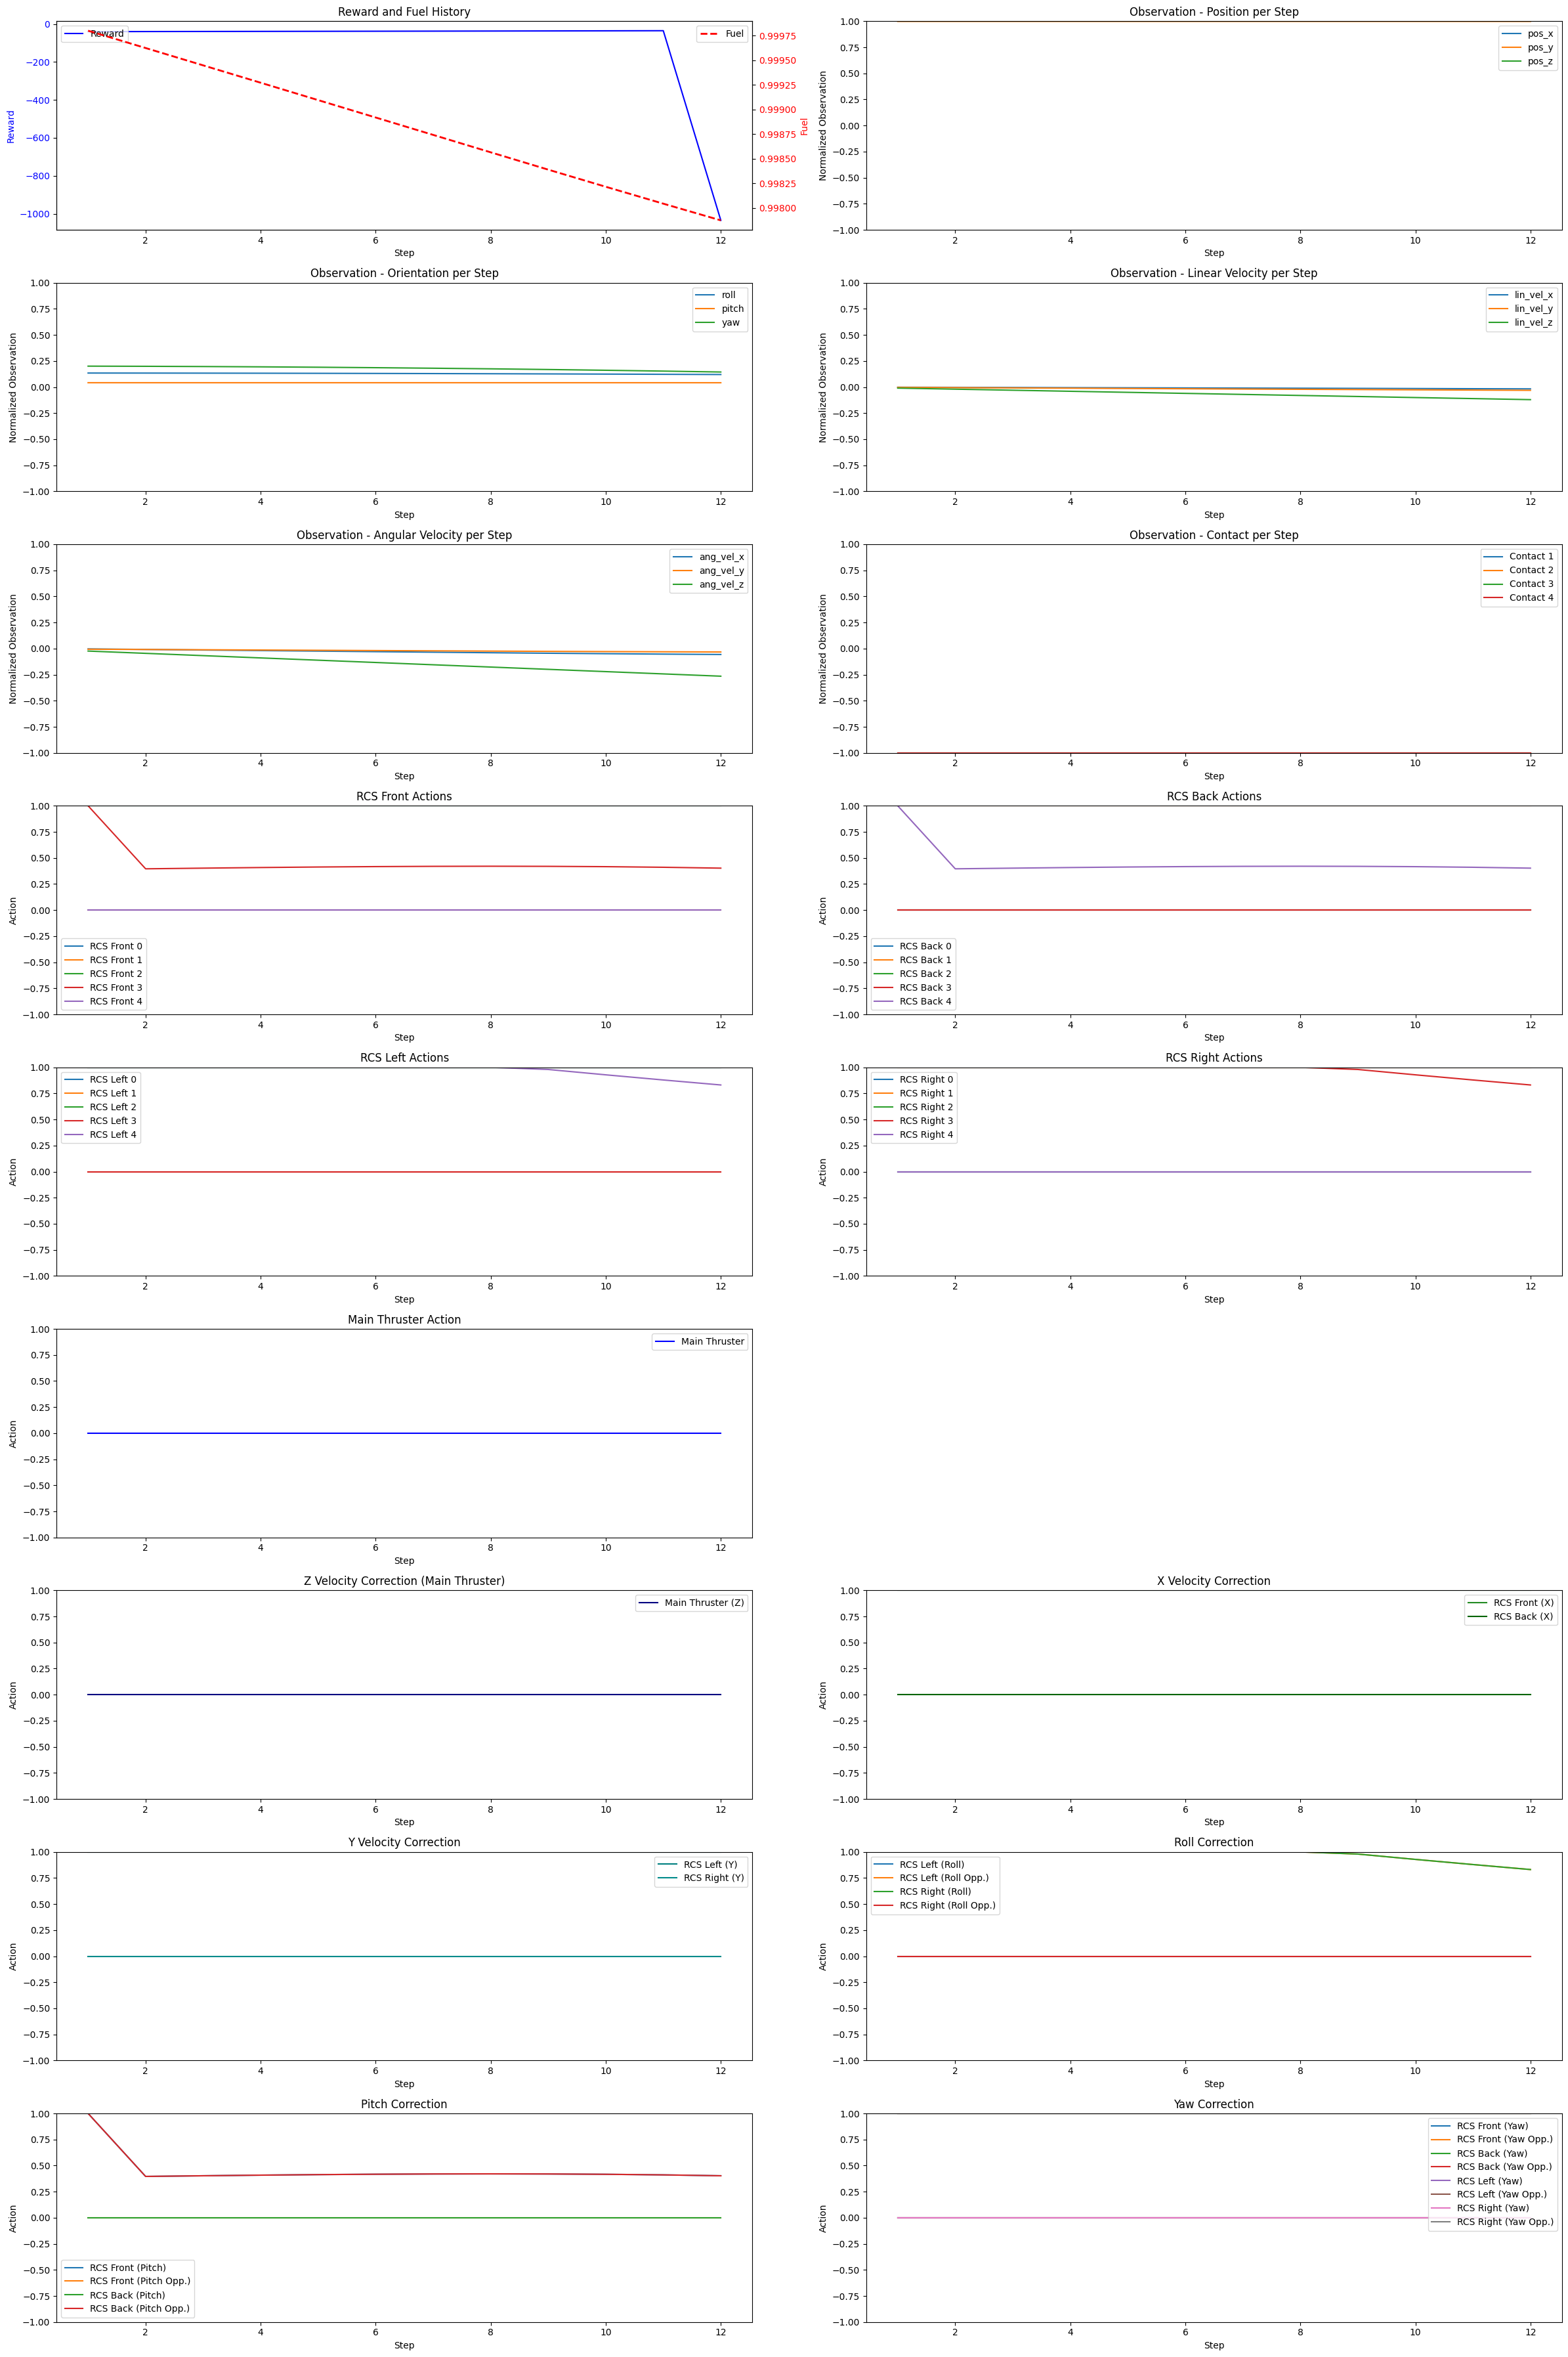

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt
import tkinter as tk
from tkinter import ttk
from LunarLander3DEnv.envs import LunarLander3DEnv  # Pastikan environment sudah tersedia
from gymnasium import spaces
import threading

########################################
# PID Controller Class
########################################

class PID:
    def __init__(self, kp, ki, kd, dt, integrator_limit=np.inf):
        self.kp = kp
        self.ki = ki
        self.kd = kd
        self.dt = dt
        self.integrator = 0.0
        self.prev_error = 0.0
        self.integrator_limit = integrator_limit

    def update(self, error):
        p_term = self.kp * error
        self.integrator += error * self.dt
        self.integrator = np.clip(self.integrator, -self.integrator_limit, self.integrator_limit)
        i_term = self.ki * self.integrator
        d_term = self.kd * ((error - self.prev_error) / self.dt)
        prev_error = self.prev_error
        self.prev_error = error
        output = p_term + i_term + d_term
        return output, p_term, i_term, d_term, prev_error

################################################################################
# Combined Display (Tkinter GUI)
# Menampilkan Observations, Actions, dan PID dalam 3 kolom
################################################################################

class CombinedDisplay(tk.Tk):
    def __init__(self):
        super().__init__()
        self.title("Lunar Lander: PID, Observations & Actions")
        self.geometry("960x1080")
        
        # Buat tiga frame utama
        self.obs_frame = ttk.LabelFrame(self, text="Observations", padding=(10,10))
        self.obs_frame.grid(row=0, column=0, padx=10, pady=10, sticky="nsew")
        
        self.act_frame = ttk.LabelFrame(self, text="Actions", padding=(10,10))
        self.act_frame.grid(row=0, column=1, padx=10, pady=10, sticky="nsew")
        
        self.pid_frame = ttk.LabelFrame(self, text="PID Control", padding=(10,10))
        self.pid_frame.grid(row=0, column=2, padx=10, pady=10, sticky="nsew")
        
        self._create_obs_widgets()
        self._create_act_widgets()
        self._create_pid_widgets()
        
        self.grid_columnconfigure(0, weight=1)
        self.grid_columnconfigure(1, weight=1)
        self.grid_columnconfigure(2, weight=2)
    
    def _create_obs_widgets(self):
        self.obs_labels = {}
        obs_names = ["pos_x", "pos_y", "pos_z", "roll", "pitch", "yaw",
                     "lin_vel_x", "lin_vel_y", "lin_vel_z",
                     "ang_vel_x", "ang_vel_y", "ang_vel_z",
                     "fuel", "contact_1", "contact_2", "contact_3", "contact_4"]
        for i, name in enumerate(obs_names):
            ttk.Label(self.obs_frame, text=name, font=("Arial", 10)).grid(row=i, column=0, padx=5, pady=2, sticky="w")
            self.obs_labels[name] = ttk.Label(self.obs_frame, text="0.0000", font=("Arial", 10))
            self.obs_labels[name].grid(row=i, column=1, padx=5, pady=2, sticky="w")
    
    def _create_act_widgets(self):
        self.action_labels = {}
        for i in range(21):
            action_name = f"Action {i}"
            ttk.Label(self.act_frame, text=action_name, font=("Arial", 10)).grid(row=i, column=0, padx=5, pady=2, sticky="w")
            self.action_labels[action_name] = ttk.Label(self.act_frame, text="0.0000", font=("Arial", 10))
            self.action_labels[action_name].grid(row=i, column=1, padx=5, pady=2, sticky="w")
    
    def _create_pid_widgets(self):
        self.pid_labels = {}
        header = ["Control", "Target", "PID Output", "Error", "Prev Error", "P", "I", "D"]
        for j, text in enumerate(header):
            ttk.Label(self.pid_frame, text=text, font=("Arial", 10)).grid(row=0, column=j, padx=5, pady=5)
        
        parameters = ["roll", "pitch", "yaw", "vel_x", "vel_y", "vel_z"]
        for i, param in enumerate(parameters):
            ttk.Label(self.pid_frame, text=param.upper(), font=("Arial", 10)).grid(row=i+1, column=0, padx=5, pady=5, sticky="w")
            for j, comp in enumerate(header[1:]):  # Mulai dari kolom Target
                lbl = ttk.Label(self.pid_frame, text="0.0000", font=("Arial", 10))
                lbl.grid(row=i+1, column=j+1, padx=5, pady=5, sticky="w")
                self.pid_labels[f"{param}_{comp}"] = lbl
    
    def update_values(self, pid_data, obs, action):
        # Jika obs memiliki 34 elemen, gunakan 17 elemen pertama sebagai current observation
        if len(obs) == 34:
            current_obs = obs[:17]
        else:
            current_obs = obs

        # Update Observations
        for key, val in zip(self.obs_labels.keys(), current_obs):
            self.obs_labels[key].config(text=f"{val:.4f}")

        # Update Actions
        for key, val in zip(self.action_labels.keys(), action):
            self.action_labels[key].config(text=f"{val:.4f}")

        # Update PID data
        for key, value in pid_data.items():
            if key in self.pid_labels:
                self.pid_labels[key].config(text=f"{value:.4f}")
        
        self.update_idletasks()

################################################################################
# Lander PID Controller (21 Action Space)
################################################################################

class LanderPIDController:
    def __init__(self, dt, max_thrust, obs_min, obs_max):
        self.dt = dt
        self.max_thrust = max_thrust
        self.obs_min = obs_min
        self.obs_max = obs_max
        
        # PID untuk kecepatan linear
        self.x_vel_pid = PID(kp=5.0, ki=0.1, kd=0.2, dt=dt, integrator_limit=1)
        self.y_vel_pid = PID(kp=5.0, ki=0.1, kd=0.2, dt=dt, integrator_limit=1)
        self.z_vel_pid = PID(kp=10.0, ki=0.1, kd=0.2, dt=dt, integrator_limit=1)
        
        # PID untuk kontrol sikap (orientasi)
        self.pitch_pid = PID(kp=10.0, ki=0.1, kd=2.0, dt=dt, integrator_limit=1)
        self.roll_pid  = PID(kp=10.0, ki=0.1, kd=2.0, dt=dt, integrator_limit=1)
        self.yaw_pid   = PID(kp=10.0, ki=0.1, kd=2.0, dt=dt, integrator_limit=1)
    
    def denormalize(self, norm_obs):
        return self.obs_min + (norm_obs + 1.0) * (self.obs_max - self.obs_min) / 2.0

    def compute_action(self, norm_obs):
        # Jika norm_obs berukuran 34, ambil current observation (17 elemen pertama)
        if len(norm_obs) == 34:
            norm_obs = norm_obs[:17]
        
        pos = norm_obs[0:3]      # [x, y, z]
        orient = norm_obs[3:6]   # [roll, pitch, yaw]
        vel = norm_obs[6:9]      # Linear velocity
        
        # Tentukan target kecepatan: target = -posisi (dengan skala)
        target_vx = -pos[0] * 2
        target_vy = -pos[1] * 2
        target_vz = -pos[2] * 0.8
        if pos[2] <= 0.1:
            target_vz = -0.05
        
        error_vx = vel[0] - target_vx
        error_vy = vel[1] - target_vy
        error_vz = vel[2] - target_vz
        
        x_vel_command, p_xvel, i_xvel, d_xvel, prev_xvel = self.x_vel_pid.update(error_vx)
        y_vel_command, p_yvel, i_yvel, d_yvel, prev_yvel = self.y_vel_pid.update(error_vy)
        z_vel_command, p_zvel, i_zvel, d_zvel, prev_zvel = self.z_vel_pid.update(error_vz)
        
        # Untuk kontrol sikap: target orientasi untuk roll dan pitch tetap 0
        roll_target = 0.0
        pitch_target = 0.0
        # Menghitung target yaw berdasarkan posisi agar lander menghadap ke titik (0,0,0)
        # Jika lander berada di (100,100,100), maka vektor yang menuju (0,0,0) adalah (-100,-100)
        yaw_target = np.arctan2(-pos[1], -pos[0])
        
        roll_error  = orient[0] - roll_target
        pitch_error = orient[1] - pitch_target
        yaw_error   = orient[2] - yaw_target
        
        roll_correction, p_r, i_r, d_r, prev_roll = self.roll_pid.update(roll_error)
        pitch_correction, p_p, i_p, d_p, prev_pitch = self.pitch_pid.update(pitch_error)
        yaw_correction, p_y, i_y, d_y, prev_yaw = self.yaw_pid.update(yaw_error)
        
        pid_data = {
            "pitch_Target": pitch_target,
            "pitch_PID Output": pitch_correction,
            "pitch_Error": pitch_error,
            "pitch_Prev Error": prev_pitch,
            "pitch_P": p_p,
            "pitch_I": i_p,
            "pitch_D": d_p,
            "roll_Target": roll_target,
            "roll_PID Output": roll_correction,
            "roll_Error": roll_error,
            "roll_Prev Error": prev_roll,
            "roll_P": p_r,
            "roll_I": i_r,
            "roll_D": d_r,
            "yaw_Target": yaw_target,  # Perhatikan di sini, target yaw sekarang dinamis
            "yaw_PID Output": yaw_correction,
            "yaw_Error": yaw_error,
            "yaw_Prev Error": prev_yaw,
            "yaw_P": p_y,
            "yaw_I": i_y,
            "yaw_D": d_y,
            "vel_x_Target": target_vx,
            "vel_x_PID Output": x_vel_command,
            "vel_x_Error": error_vx,
            "vel_x_Prev Error": prev_xvel,
            "vel_x_P": p_xvel,
            "vel_x_I": i_xvel,
            "vel_x_D": d_xvel,
            "vel_y_Target": target_vy,
            "vel_y_PID Output": y_vel_command,
            "vel_y_Error": error_vy,
            "vel_y_Prev Error": prev_yvel,
            "vel_y_P": p_yvel,
            "vel_y_I": i_yvel,
            "vel_y_D": d_yvel,
            "vel_z_Target": target_vz,
            "vel_z_PID Output": z_vel_command,
            "vel_z_Error": error_vz,
            "vel_z_Prev Error": prev_zvel,
            "vel_z_P": p_zvel,
            "vel_z_I": i_zvel,
            "vel_z_D": d_zvel,
        }
        
        # Definisikan aksi untuk 21 aktuator (contoh sederhana)
        action = [
            -z_vel_command,      # Main thruster: gunakan -z_vel_command
            x_vel_command,       # RCS Front
            -yaw_correction,
            yaw_correction,
            pitch_correction,
            -pitch_correction,
            -x_vel_command,      # RCS Back
            yaw_correction,
            -yaw_correction,
            -pitch_correction,
            pitch_correction,
            yaw_correction,      # RCS Left
            -yaw_correction,
            y_vel_command,
            -roll_correction,
            roll_correction,
            -yaw_correction,     # RCS Right
            yaw_correction,
            -y_vel_command,
            roll_correction,
            -roll_correction
        ]
        action_vector = np.clip(action, 0, 1)
        return action_vector, pid_data

################################################################################
# Program Utama: Simulasi, GUI, dan Plotting
################################################################################

import matplotlib.pyplot as plt
import threading

def simulation_loop(env, controller, gui, dt, results):
    obs_list = []
    action_list = []
    reward_list = []
    fuel_list = []
    step_list = []
    
    norm_obs, info = env.reset()
    done = False
    while not done:
        # Gunakan current observation (17 elemen pertama)
        action, pid_data = controller.compute_action(norm_obs)
        
        norm_obs, reward, terminated, truncated, info = env.step(action)
        action_list.append(np.array(action))
        obs_list.append(norm_obs.copy())
        reward_list.append(reward)
        # Fuel ada di current observation (indeks 12)
        fuel_list.append(norm_obs[12])
        step_list.append(env.step_counter)
        done = terminated or truncated
        
        # Update GUI secara thread-safe menggunakan .after()
        gui.after(0, gui.update_values, pid_data, norm_obs, action)
        env.render()
    
    env.close()
    print("SELESAI")
    results['obs'] = np.array(obs_list)
    results['action'] = np.array(action_list)
    results['reward'] = np.array(reward_list)
    results['fuel'] = np.array(fuel_list)
    results['step'] = np.array(step_list)
    gui.after(0, gui.destroy)
    
if __name__ == '__main__':
    env = LunarLander3DEnv(render_mode='human', start_position=[100, 100, 100], planet="earth")
    dt = 1.0 / env.render_fps
    env.difficulty = 1
    norm_obs, info = env.reset()
    controller = LanderPIDController(dt, env.max_thrust, env.obs_min, env.obs_max)
    
    gui = CombinedDisplay()
    
    results = {}
    sim_thread = threading.Thread(target=simulation_loop, args=(env, controller, gui, dt, results), daemon=True)
    sim_thread.start()
    
    gui.mainloop()   
    # Setelah GUI ditutup, lakukan plotting (jika simulasi telah selesai)
    print(f"REWARD : {results['reward'].sum()}")
    if results:
        obs_history = results['obs']
        action_history = results['action']
        reward_history = results['reward']
        fuel_history = results['fuel']
        step_history = results['step']
                        
        # Ubah layout subplot menjadi 9 baris x 2 kolom
        fig, axs = plt.subplots(9, 2, figsize=(24, 36))
                        
        # --- Baris 0: Reward & Observations ---
        # Baris 0, Kolom 0: Plot Reward dan Fuel over Steps
        ax = axs[0, 0]
        ax.plot(step_history, reward_history, 'b-', label='Reward')
        ax.set_xlabel('Step')
        ax.set_ylabel('Reward', color='b')
        ax.tick_params(axis='y', labelcolor='b')
        axb = ax.twinx()
        axb.plot(step_history, fuel_history, 'r--', label='Fuel', linewidth=2)
        axb.set_ylabel('Fuel', color='r')
        axb.tick_params(axis='y', labelcolor='r')
        ax.set_title('Reward and Fuel History')
        ax.legend(loc='upper left')
        axb.legend(loc='upper right')
        
        # Baris 0, Kolom 1: Observations - Position
        obs_labels_pos = ["pos_x", "pos_y", "pos_z"]
        obs_subset_pos = obs_history[:, 0:3]
        ax = axs[0, 1]
        for i in range(obs_subset_pos.shape[1]):
                ax.plot(step_history, obs_subset_pos[:, i], label=obs_labels_pos[i])
        ax.set_xlabel('Step')
        ax.set_ylabel('Normalized Observation')
        ax.set_title('Observation - Position per Step')
        ax.set_ylim(-1, 1) , ax.legend()
        
        # --- Baris 1: Observations ---
        # Baris 1, Kolom 0: Observations - Orientation
        obs_labels_ori = ["roll", "pitch", "yaw"]
        obs_subset_ori = obs_history[:, 3:6]
        ax = axs[1, 0]
        for i in range(obs_subset_ori.shape[1]):
                ax.plot(step_history, obs_subset_ori[:, i], label=obs_labels_ori[i])
        ax.set_xlabel('Step')
        ax.set_ylabel('Normalized Observation')
        ax.set_title('Observation - Orientation per Step')
        ax.set_ylim(-1, 1) , ax.legend()
        
        # Baris 1, Kolom 1: Observations - Linear Velocity
        obs_labels_lin_vel = ["lin_vel_x", "lin_vel_y", "lin_vel_z"]
        obs_subset_lin_vel = obs_history[:, 6:9]
        ax = axs[1, 1]
        for i in range(obs_subset_lin_vel.shape[1]):
                ax.plot(step_history, obs_subset_lin_vel[:, i], label=obs_labels_lin_vel[i])
        ax.set_xlabel('Step')
        ax.set_ylabel('Normalized Observation')
        ax.set_title('Observation - Linear Velocity per Step')
        ax.set_ylim(-1, 1) , ax.legend()
        
        # --- Baris 2: Observations ---
        # Baris 2, Kolom 0: Observations - Angular Velocity
        obs_labels_ang_vel = ["ang_vel_x", "ang_vel_y", "ang_vel_z"]
        obs_subset_ang_vel = obs_history[:, 9:12]
        ax = axs[2, 0]
        for i in range(obs_subset_ang_vel.shape[1]):
                ax.plot(step_history, obs_subset_ang_vel[:, i], label=obs_labels_ang_vel[i])
        ax.set_xlabel('Step')
        ax.set_ylabel('Normalized Observation')
        ax.set_title('Observation - Angular Velocity per Step')
        ax.set_ylim(-1, 1) , ax.legend()
        
        # Baris 2, Kolom 1: Observations - Contact Sensors
        contact_labels = ["Contact 1", "Contact 2", "Contact 3", "Contact 4"]
        obs_subset_contact = obs_history[:, 13:17]
        ax = axs[2, 1]
        for i in range(obs_subset_contact.shape[1]):
                ax.plot(step_history, obs_subset_contact[:, i], label=contact_labels[i])
        ax.set_xlabel('Step')
        ax.set_ylabel('Normalized Observation')
        ax.set_title('Observation - Contact per Step')
        ax.set_ylim(-1, 1) , ax.legend()
        
        # --- Baris 3 & 4: Aksi Berdasarkan Grup RCS (asli) ---
        # Baris 3, Kolom 0: Action History - RCS Front
        rcs_front_actions = action_history[:, 1:6]
        ax = axs[3, 0]
        for i in range(rcs_front_actions.shape[1]):
                ax.plot(step_history, rcs_front_actions[:, i], label=f'RCS Front {i}')
        ax.set_xlabel("Step")
        ax.set_ylabel("Action")
        ax.set_title("RCS Front Actions")
        ax.set_ylim(-1, 1) , ax.legend()
        
        # Baris 3, Kolom 1: Action History - RCS Back
        rcs_back_actions = action_history[:, 6:11]
        ax = axs[3, 1]
        for i in range(rcs_back_actions.shape[1]):
                ax.plot(step_history, rcs_back_actions[:, i], label=f'RCS Back {i}')
        ax.set_xlabel("Step")
        ax.set_ylabel("Action")
        ax.set_title("RCS Back Actions")
        ax.set_ylim(-1, 1) , ax.legend()
        
        # Baris 4, Kolom 0: Action History - RCS Left
        rcs_left_actions = action_history[:, 11:16]
        ax = axs[4, 0]
        for i in range(rcs_left_actions.shape[1]):
                ax.plot(step_history, rcs_left_actions[:, i], label=f'RCS Left {i}')
        ax.set_xlabel("Step")
        ax.set_ylabel("Action")
        ax.set_title("RCS Left Actions")
        ax.set_ylim(-1, 1) , ax.legend()
        
        # Baris 4, Kolom 1: Action History - RCS Right
        rcs_right_actions = action_history[:, 16:21]
        ax = axs[4, 1]
        for i in range(rcs_right_actions.shape[1]):
                ax.plot(step_history, rcs_right_actions[:, i], label=f'RCS Right {i}')
        ax.set_xlabel("Step")
        ax.set_ylabel("Action")
        ax.set_title("RCS Right Actions")
        ax.set_ylim(-1, 1) , ax.legend()
        
        # Baris 5, Kolom 0: Main Thruster Action
        main_thruster_actions = action_history[:, 0]
        ax = axs[5, 0]
        ax.plot(step_history, main_thruster_actions, label="Main Thruster", color='blue')
        ax.set_xlabel("Step")
        ax.set_ylabel("Action")
        ax.set_title("Main Thruster Action")
        ax.set_ylim(-1, 1) , ax.legend()
        
        # Baris 5, Kolom 1: Kosongkan (atau gunakan untuk informasi lain)
        axs[5, 1].axis('off')
        
        # --- Baris 6-8: Grafik Berdasarkan Sinyal Kontrol (aksi per actuator) ---
        # Urutannya: Z Velocity Correction, X Velocity Correction, Y Velocity Correction, Roll Correction, Pitch Correction, Yaw Correction.
        
        # Baris 6, Kolom 0: Z Velocity Correction (Main Thruster)
        ax = axs[6, 0]
        ax.plot(step_history, action_history[:, 0], label="Main Thruster (Z)", color='navy')
        ax.set_xlabel("Step")
        ax.set_ylabel("Action")
        ax.set_title("Z Velocity Correction (Main Thruster)")
        ax.set_ylim(-1, 1) , ax.legend()
        
        # Baris 6, Kolom 1: X Velocity Correction (RCS depan & belakang)
        ax = axs[6, 1]
        ax.plot(step_history, action_history[:, 1], label="RCS Front (X)", color='forestgreen')
        ax.plot(step_history, action_history[:, 6], label="RCS Back (X)", color='darkgreen')
        ax.set_xlabel("Step")
        ax.set_ylabel("Action")
        ax.set_title("X Velocity Correction")
        ax.set_ylim(-1, 1) , ax.legend()
        
        # Baris 7, Kolom 0: Y Velocity Correction (RCS kiri & kanan)
        ax = axs[7, 0]
        ax.plot(step_history, action_history[:, 13], label="RCS Left (Y)", color='teal')
        ax.plot(step_history, action_history[:, 18], label="RCS Right (Y)", color='darkcyan',)
        ax.set_xlabel("Step")
        ax.set_ylabel("Action")
        ax.set_title("Y Velocity Correction")
        ax.set_ylim(-1, 1) , ax.legend()
        
        # Baris 7, Kolom 1: Roll Correction (misalnya, ambil dua actuator dari grup kanan)
        ax = axs[7, 1]
        
        ax.plot(step_history, action_history[:, 14], label="RCS Left (Roll)",)
        ax.plot(step_history, action_history[:, 15], label="RCS Left (Roll Opp.)", )
        ax.plot(step_history, action_history[:, 19], label="RCS Right (Roll)", )
        ax.plot(step_history, action_history[:, 20], label="RCS Right (Roll Opp.)",)
        ax.set_xlabel("Step")
        ax.set_ylabel("Action")
        ax.set_title("Roll Correction")
        ax.set_ylim(-1, 1) , ax.legend()
        
        # Baris 8, Kolom 0: Pitch Correction (misalnya, ambil actuator dari grup depan dan belakang)
        ax = axs[8, 0]
        
        ax.plot(step_history, action_history[:, 4], label="RCS Front (Pitch)",)
        ax.plot(step_history, action_history[:, 5], label="RCS Front (Pitch Opp.)",)
        ax.plot(step_history, action_history[:, 9], label="RCS Back (Pitch)",)
        ax.plot(step_history, action_history[:, 10], label="RCS Back (Pitch Opp.)",)
        ax.set_xlabel("Step")
        ax.set_ylabel("Action")
        ax.set_title("Pitch Correction")
        ax.set_ylim(-1, 1) , ax.legend()
        
        # Baris 8, Kolom 1: Yaw Correction (misalnya, ambil actuator dari grup depan dan belakang)
        ax = axs[8, 1]
        ax.plot(step_history, action_history[:, 2], label="RCS Front (Yaw)",)
        ax.plot(step_history, action_history[:, 3], label="RCS Front (Yaw Opp.)",)
        ax.plot(step_history, action_history[:, 7], label="RCS Back (Yaw)",)
        ax.plot(step_history, action_history[:, 8], label="RCS Back (Yaw Opp.)",)
        ax.plot(step_history, action_history[:, 11], label="RCS Left (Yaw)",)
        ax.plot(step_history, action_history[:, 12], label="RCS Left (Yaw Opp.)",)
        ax.plot(step_history, action_history[:, 16], label="RCS Right (Yaw)",)
        ax.plot(step_history, action_history[:, 17], label="RCS Right (Yaw Opp.)",)
        ax.set_xlabel("Step")
        ax.set_ylabel("Action")
        ax.set_title("Yaw Correction")
        ax.set_ylim(-1, 1) , ax.legend()
        
        plt.tight_layout()
        plt.show()


In [1]:
import numpy as np

# ---------------------------
# Simulasi parameter observasi
# ---------------------------

# Asumsi semua parameter observasi bernilai 0.5
# Posisi: [x, y, z]
pos = [1, 1, 1]

# Orientasi: [roll, pitch, yaw]
orient = [0.001, 0.001, 0.001]

# Kecepatan linear: [vx, vy, vz]
lin_vel = [-1.0, -1.0, -0.5]

# Kecepatan sudut: [roll_rate, pitch_rate, yaw_rate]
ang_vel = [0.001, 0.001, 0.001]

# Fuel (diasumsikan nilai 0.5, bukan nilai yang sudah dinormalisasi misalnya)
fuel = 0.9

# Sensor kontak (4 sensor), masing-masing bernilai 0.5
contact = [-1., -1.,-1., -1.]

# Aksi: vektor 21-dimensi, semua nilainya 0.5
action = np.full(21, 1.0)

# ---------------------------
# Perhitungan komponen reward
# ---------------------------

# 1. Stability Reward (untuk roll, pitch, yaw dan kecepatan sudut)
roll_error = abs(orient[0])
pitch_error = abs(orient[1])
yaw_error = abs(orient[2])
total_orientation_error = roll_error + pitch_error + yaw_error

# Total error kecepatan sudut (diasumsikan untuk 3 komponen)
ang_vel_error = np.sum(np.abs(ang_vel[:3]))

stability_reward = -100.0 * total_orientation_error - 10 * ang_vel_error

# 2. Velocity Reward (vx, vy mendekati 0; vz mendekati -1)
target_vx = -pos[0]
target_vy = -pos[1]
target_vz = -pos[2]/2

vx_error = abs(lin_vel[0] - target_vx)
vy_error = abs(lin_vel[1] - target_vy)
vz_error = abs(lin_vel[2] - target_vz)
total_velocity_error = vx_error + vy_error + vz_error

velocity_reward = -10.0 * total_velocity_error

# 3. Position Penalty (mendekati target (0,0,0))
distance = np.linalg.norm(np.array(pos) - np.array([0.0, 0.0, 0.0]))
position_penalty = -1.0 * distance

# 4. Thruster Penalty
thruster_penalty = -0.05 * (abs(action[0]) + np.sum(np.abs(action)))

# 5. Survival Reward per Step
survival_reward = 0.1

# 6. Landing Bonus (jika setidaknya 3 sensor kontak > -1.0)
if np.sum(np.array(contact) > -1.0) >= 3:
    landing_bonus = 100.0
else:
    landing_bonus = 0.0

# Total reward (sebelum mengecek kondisi terminasi)
total_reward = (stability_reward + velocity_reward + position_penalty +
                survival_reward + landing_bonus - thruster_penalty)

# ---------------------------
# Tampilkan hasil perhitungan
# ---------------------------
print("=== Perhitungan Reward ===\n")

# Stability Reward
print("1. Stability Reward:")
print(f"   Roll Error    : {roll_error}")
print(f"   Pitch Error   : {pitch_error}")
print(f"   Yaw Error     : {yaw_error}")
print(f"   Total Orientation Error : {total_orientation_error}")
print(f"   Angular Velocity Error  : {ang_vel_error}")
print(f"   Stability Reward        : {stability_reward}\n")

# Velocity Reward
print("2. Velocity Reward:")
print(f"   vx_error : {vx_error}")
print(f"   vy_error : {vy_error}")
print(f"   vz_error : {vz_error}")
print(f"   Total Velocity Error : {total_velocity_error}")
print(f"   Velocity Reward      : {velocity_reward}\n")

# Position Penalty
print("3. Position Penalty:")
print(f"   Distance to (0,0,0) : {distance}")
print(f"   Position Penalty    : {position_penalty}\n")

# Thruster Penalty
print("4. Thruster Penalty:")
print(f"   Thruster Penalty    : {thruster_penalty}\n")

# Survival Reward
print("5. Survival Reward:")
print(f"   Survival Reward     : {survival_reward}\n")

# Landing Bonus
print("6. Landing Bonus:")
print(f"   Landing Bonus       : {landing_bonus}\n")

# Total Reward
print("=== Total Reward ===")
print(f"Total Reward : {total_reward}\n")

# Cek kondisi terminasi (tidak terminated dalam simulasi ini)
terminated = False
truncated = False
if abs(orient[0]) > 0.75 or abs(orient[1]) > 0.75 or fuel <= 0 or pos[2] < 0:
    terminated = True
    total_reward = -100.0  # Penalti berat
    print("Kondisi terminasi terpenuhi: Episode dianggap gagal!")
else:
    print("Episode tidak terminated.")

print(f"Terminated: {terminated}, Truncated: {truncated}")


=== Perhitungan Reward ===

1. Stability Reward:
   Roll Error    : 0.001
   Pitch Error   : 0.001
   Yaw Error     : 0.001
   Total Orientation Error : 0.003
   Angular Velocity Error  : 0.003
   Stability Reward        : -0.32999999999999996

2. Velocity Reward:
   vx_error : 0.0
   vy_error : 0.0
   vz_error : 0.0
   Total Velocity Error : 0.0
   Velocity Reward      : -0.0

3. Position Penalty:
   Distance to (0,0,0) : 1.7320508075688772
   Position Penalty    : -1.7320508075688772

4. Thruster Penalty:
   Thruster Penalty    : -1.1

5. Survival Reward:
   Survival Reward     : 0.1

6. Landing Bonus:
   Landing Bonus       : 0.0

=== Total Reward ===
Total Reward : -0.8620508075688771

Episode tidak terminated.
Terminated: False, Truncated: False


In [3]:
import numpy as np

# ---------------------------
# Simulasi parameter observasi
# ---------------------------

pos = [1, 1, 1]               # [x, y, z]
orient = [0.001, 0.001, 0.001]  # [roll, pitch, yaw]
lin_vel = [-1.0, -1.0, -0.5]    # [vx, vy, vz]
ang_vel = [0.001, 0.001, 0.001] # [roll_rate, pitch_rate, yaw_rate]
fuel = 0.9
contact = [-1., -1., -1., -1.]  # 4 sensor kontak
action = np.full(21, 1.0)       # aksi 21 dimensi

# ---------------------------
# 1. Stability Reward (menggunakan fungsi eksponensial)
# ---------------------------
roll_error = abs(orient[0])
pitch_error = abs(orient[1])
yaw_error = abs(orient[2])
total_orientation_error = roll_error + pitch_error + yaw_error

ang_vel_error = np.sum(np.abs(ang_vel))

r_orientation = np.exp(-100.0 * (total_orientation_error ** 2))
r_ang_vel = np.exp(-10.0 * (ang_vel_error ** 2))
stability_reward = r_orientation + r_ang_vel

# ---------------------------
# 2. Velocity Reward
# ---------------------------
target_vx = -pos[0]
target_vy = -pos[1]
target_vz = -pos[2] / 2.0

vx_error = abs(lin_vel[0] - target_vx)
vy_error = abs(lin_vel[1] - target_vy)
vz_error = abs(lin_vel[2] - target_vz)
total_velocity_error = vx_error + vy_error + vz_error

velocity_reward = np.exp(-10.0 * (total_velocity_error ** 2))

# ---------------------------
# 3. Position Reward
# ---------------------------
distance = np.linalg.norm(np.array(pos) - np.array([0.0, 0.0, 0.0]))
position_reward = np.exp(-1.0 * (distance ** 2))

# ---------------------------
# 4. Thruster dan Action Regularization
# ---------------------------
# Misalkan: 
# - Elemen pertama dari 'action' mewakili thruster utama.
# - Sisa elemen 'action' mewakili aksi-aksi lain (misalnya kontrol sendi).
thruster_value = action[0]
other_actions = action[1:]

# Thruster Reward: penalti hanya dari nilai thruster utama
thruster_reward = np.exp(-0.05 * abs(thruster_value))

# Action Regularization Reward: penalti dari sisa aksi agar tidak terlalu besar
k_reg = 0.01  # koefisien regularisasi
action_regularization_reward = np.exp(-k_reg * np.sum(other_actions ** 2))

# ---------------------------
# 5. Survival Reward
# ---------------------------
survival_reward = 0.1

# ---------------------------
# 6. Landing Bonus
# ---------------------------
n_good_contacts = np.sum(np.array(contact) > -1.0)
missing_contacts = max(0, 3 - n_good_contacts)
landing_reward = 100.0 * np.exp(-10.0 * (missing_contacts ** 2))

# ---------------------------
# Total Reward
# ---------------------------
total_reward = (stability_reward
                + velocity_reward
                + position_reward
                + thruster_reward
                + action_regularization_reward
                + survival_reward
                + landing_reward)

# ---------------------------
# Cek kondisi terminasi
# ---------------------------
terminated = False
truncated = False

if abs(orient[0]) > 0.75 or abs(orient[1]) > 0.75 or fuel <= 0 or pos[2] < 0:
    terminated = True
    total_reward = -100.0

# ---------------------------
# Tampilkan hasil
# ---------------------------
print("=== Perhitungan Reward (Eksponensial + Regularisasi Terpisah) ===\n")

print(f"Stability Reward             : {stability_reward:.4f}")
print(f"Velocity Reward              : {velocity_reward:.4f}")
print(f"Position Reward              : {position_reward:.4f}")
print(f"Thruster Reward (elemen 0)     : {thruster_reward:.4f}")
print(f"Action Regularization Reward : {action_regularization_reward:.4f}")
print(f"Survival Reward              : {survival_reward:.4f}")
print(f"Landing Reward               : {landing_reward:.4f}")

print("\n=== Total Reward ===")
print(f"Total Reward : {total_reward:.4f}\n")

if terminated:
    print("Kondisi terminasi terpenuhi: Episode dianggap gagal!")
else:
    print("Episode tidak terminated.")

print(f"Terminated: {terminated}, Truncated: {truncated}")


=== Perhitungan Reward (Eksponensial + Regularisasi Terpisah) ===

Stability Reward             : 1.9990
Velocity Reward              : 1.0000
Position Reward              : 0.0498
Thruster Reward (elemen 0)     : 0.9512
Action Regularization Reward : 0.8187
Survival Reward              : 0.1000
Landing Reward               : 0.0000

=== Total Reward ===
Total Reward : 4.9188

Episode tidak terminated.
Terminated: False, Truncated: False


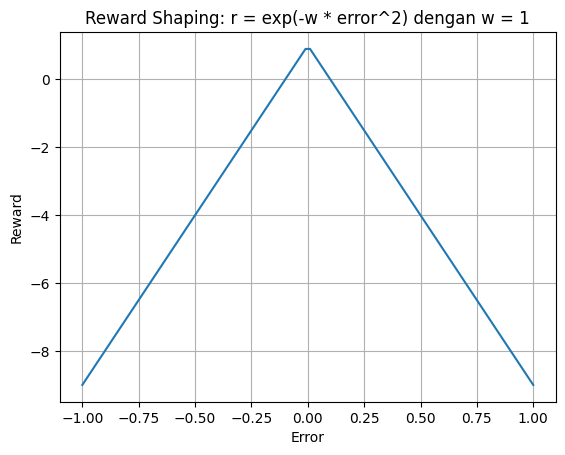

In [84]:
import numpy as np
import matplotlib.pyplot as plt

# Misalnya, kita set weight = 1
w = 10.0
# 100 nilai error dari -1 hingga 1
error = np.linspace(-1, 1, 100)
# Hitung r_i sesuai fungsi
r = 1 - 10 * abs(error)


# Plot hasilnya
plt.plot(error, r)
plt.xlabel('Error')
plt.ylabel('Reward')
plt.title('Reward Shaping: r = exp(-w * error^2) dengan w = 1')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np



target_pos = np.array([0, 0, 0])
pos = np.array([-0.999,0.999,0.999])

target_vel = np.array([-0.75, -0.75, -0.75])
lin_vel = np.array([-0.5, -0.5, -0.9])

orient = np.array([-0.05, -0.05, 0.05])

ang_vel = np.array([0.2, 0.2, 0.2])

reward = 30 - 10 * np.linalg.norm(target_pos - pos)**2
print(reward)

reward = 10 - 100 * np.linalg.norm(target_vel - lin_vel)**2
print(reward)

reward = 10 - 100.0 * np.linalg.norm(orient)**2
print(reward)

reward = -10.0 * np.linalg.norm(ang_vel)**2
print(reward)


0.05996999999999986
-4.750000000000002
9.25
-1.2000000000000004


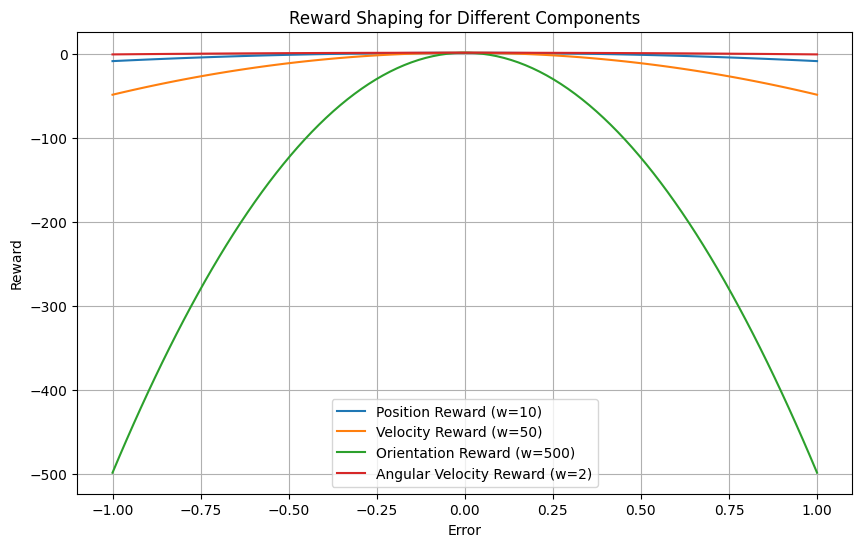

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Error range for plotting
error = np.linspace(-1, 1, 100)

# Weight values
w_pos = 10
w_vel = 50
w_orient = 500
w_ang_vel = 2

# Given values
target_pos = np.array([0, 0, 0])
pos = np.array([-0.3, 0.3, 0.3])

target_vel = np.array([-0.9, -0.9, -0.9])
lin_vel = np.array([-0.75, -0.75, -0.75])

orient = np.array([-0.25, -0.25, 0.25])
ang_vel = np.array([0.2, 0.2, 0.2])

# Compute rewards
reward_pos = 1 - w_pos * np.linalg.norm(target_pos - pos)**2
reward_vel = 1 - w_vel * np.linalg.norm(target_vel - lin_vel)**2
reward_orient = 1 -w_orient * np.linalg.norm(orient)**2
reward_ang_vel = 1 -w_ang_vel * np.linalg.norm(ang_vel)**2

# Compute reward shaping functions
r_pos = 1 - w_pos * error**2
r_vel = 1 - w_vel * error**2
r_orient =  1 -w_orient * error**2
r_ang_vel = 1 -w_ang_vel * error**2

# Plot results
plt.figure(figsize=(10, 6))

plt.plot(error, r_pos, label=f'Position Reward (w={w_pos})')
plt.plot(error, r_vel, label=f'Velocity Reward (w={w_vel})')
plt.plot(error, r_orient, label=f'Orientation Reward (w={w_orient})')
plt.plot(error, r_ang_vel, label=f'Angular Velocity Reward (w={w_ang_vel})')



plt.xlabel('Error')
plt.ylabel('Reward')
plt.title('Reward Shaping for Different Components')
plt.legend()
plt.grid(True)
plt.show()
